# Kinship modelling

## Import required packages and set settings

In [118]:
import pandas as pd
import glasbey
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    cross_val_predict,
    HalvingGridSearchCV
)
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier, LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import math

rcParams.update({'font.size': 21})
plt.rcParams['figure.dpi'] = 100
px = 1/plt.rcParams['figure.dpi']

## Initialize some utility functions

In [119]:
def CM_report(
    y_true,
    y_pred,
    *,
    experiment_names: list[str] | None = None,
    title: str | None = "Confusion Matrix",
    with_metrics: bool | None = False
):
    n_experiments = len(y_pred)
    experiments_are_odd = n_experiments % 2

    if experiment_names is None:
        experiment_names = [f"Exp{i}" for i in range(n_experiments)]

    if n_experiments == 1:
        # TODO: rework to make it more readable
        experiments_are_odd = 0
        n_rows = 1
        n_cols = 1
    else:
        n_cols = 2
        if experiments_are_odd:
            n_rows = int((2 * math.ceil(n_experiments / 2)) / n_cols)
            n_cols *= 2
        else:
            n_rows = int(n_experiments / n_cols)

    # fig_height = 12 * n_rows
    # fig_width = 25
    fig = plt.figure(figsize=(2080*px, 1024*px))
    height_list = list(1 for _ in range(n_rows))
    if with_metrics:
        height += [0.01]
    gs = fig.add_gridspec(
        nrows=n_rows + (1 if with_metrics else 0),
        ncols=n_cols,
        width_ratios=tuple(1 for _ in range(n_cols)),
        height_ratios=tuple(height_list),
        wspace=0,hspace=0
    )

    plot_axs = []
    column_step = 2 if experiments_are_odd else 1
    for i in range(n_rows - experiments_are_odd):
        for j in range(0, n_cols, column_step):
            plot_axs.append(fig.add_subplot(gs[i, j : j + column_step]))

    if experiments_are_odd:
        plot_axs.append(fig.add_subplot(gs[n_rows - 1, 1 : n_cols - 1]))


    metrics = compute_metrics(y_true, y_pred)
    colors_cells = list(map(list, zip(*best_metric_colored(metrics))))
    metrics_cells = list(map(list, zip(*metrics)))

    fig.suptitle(title)

    for i, (name) in enumerate(experiment_names):
        plot_axs[i].set_title(name)
        ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred[i],
            normalize="true",
            ax=plot_axs[i],
            values_format=".1g",
            colorbar=False,
        )
        plot_axs[i].set_xticklabels(plot_axs[i].get_xticklabels(), rotation=90)
        
    if with_metrics:
        table_ax = fig.add_subplot(gs[-1, :])

        table_ax.set_title("Weighted metrics:")
        table_ax.axis("off")
        table_ax.table(
            cellText=metrics_cells,
            colLabels=["Recall", "Precision", "F1"],
            rowLabels=experiment_names,
            cellColours=colors_cells,
            cellLoc="center",
        )

    fig.tight_layout()
    return fig


def compute_metrics(y_true, y_pred):
    recalls = []
    precisions = []
    f1s = []
    for p in y_pred:
        recalls.append(recall_score(y_true, p, average="weighted"))
        precisions.append(
            precision_score(y_true, p, average="weighted", zero_division=0)
        )
        f1s.append(f1_score(y_true, p, average="weighted"))

    return [recalls, precisions, f1s]


def compute_metrics_per_class(y_true, y_pred, labels):
    recalls = []
    precisions = []
    f1s = []
    for p in y_pred:
        recall = dict(zip(labels, recall_score(y_true, p, average=None, labels=labels)))
        precision = dict(
            zip(
                labels,
                precision_score(
                    y_true, p, average=None, zero_division=0, labels=labels
                ),
            )
        )
        f1 = dict(zip(labels, f1_score(y_true, p, average=None, labels=labels)))

    return {"recall": recall, "precision": precision, "f1": f1}


def best_metric_colored(metrics):
    color_list = []
    for metric in metrics:
        max_idx = max(range(len(metric)), key=lambda x: metric[x])
        color_list.append(
            ["#b9eba7" if i == max_idx else "w" for i, _ in enumerate(metric)]
        )

    return color_list


## Load dataset

In [50]:
sheet_to_df_map = pd.read_excel("parentela_data.xlsx", sheet_name=None)

## Group classes by kinship type

In [51]:
df = pd.DataFrame()
for sheet in sheet_to_df_map.values():
    df = pd.concat([df, sheet], ignore_index=True)

df.reset_index(drop=True, inplace=True)
df = df.loc[:, ["id1", "id2", "Relazione_nota", "k0", "k1", "k2", "LR"]]
df.rename(columns={"Relazione_nota": "label"}, inplace=True)
df["label"] = df["label"].replace("UN ", "UN")
df["label"] = df["label"].replace(["HS","GP","ZI"], "HS-GP-ZI")
df["label"] = df["label"].replace(["CO","PP","GG","HU"], "CO-PP-GG-HU")
df["label"] = df["label"].replace(["GGG","PPP","1C1R"], "GGG-PPP-1C1R")


,id1,id2,label,k0,k1,k2,LR
0,1,10,UN,0.992687,0.005487,0.001825,1.064287
1,1,10,UN,0.993958,0.000000,0.006042,1.191301
2,1,10,UN,0.993956,0.006044,0.000000,1.021294
3,1,10,UN,0.985539,0.000000,0.014461,2.674207
4,1,10,UN,0.976843,0.023157,0.000000,1.384695


## Modelling

### Create polynomial features for testing

In [52]:
maxnum = 1e300
y = df.loc[:, "label"]
x_LR = df.loc[:, ["k0", "k1", "k2", "LR"]]
x = df.loc[:, ["k0", "k1", "k2"]]
x_LR["LR"].loc[x_LR["LR"] == np.inf] = maxnum
x_LR["LR"].loc[x_LR["LR"] > maxnum] = maxnum
x_LR["LR"] = np.log10(x_LR["LR"])
x_LR.to_csv("parentela_preprocessed.csv")

poly_features_LR = PolynomialFeatures(degree=2, include_bias=False)
poly_features = PolynomialFeatures(degree=2, include_bias=False)
px_LR = poly_features_LR.fit_transform(x_LR)
px = poly_features.fit_transform(x)


### Split and scale the data

In [53]:
(
    x_train_LR,
    x_test_LR,
    x_train,
    x_test,
    px_train_LR,
    px_test_LR,
    px_train,
    px_test,
    y_train,
    y_test,
) = train_test_split(x_LR, x, px_LR, px, y, test_size=0.2, stratify=y, random_state=42)

scaler_LR = StandardScaler()
scaler = StandardScaler()
scaler_pLR = StandardScaler()
scaler_p = StandardScaler()

scaled_x_train_LR = scaler_LR.fit_transform(x_train_LR)
scaled_x_test_LR = scaler_LR.transform(x_test_LR)

scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)

scaled_px_train_LR = scaler_pLR.fit_transform(px_train_LR)
scaled_px_test_LR = scaler_pLR.transform(px_test_LR)

scaled_px_train = scaler_p.fit_transform(px_train)
scaled_px_test = scaler_p.transform(px_test)


/tmp/ipykernel_150572/2249703306.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/tmp/ipykernel_150572/2249703306.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


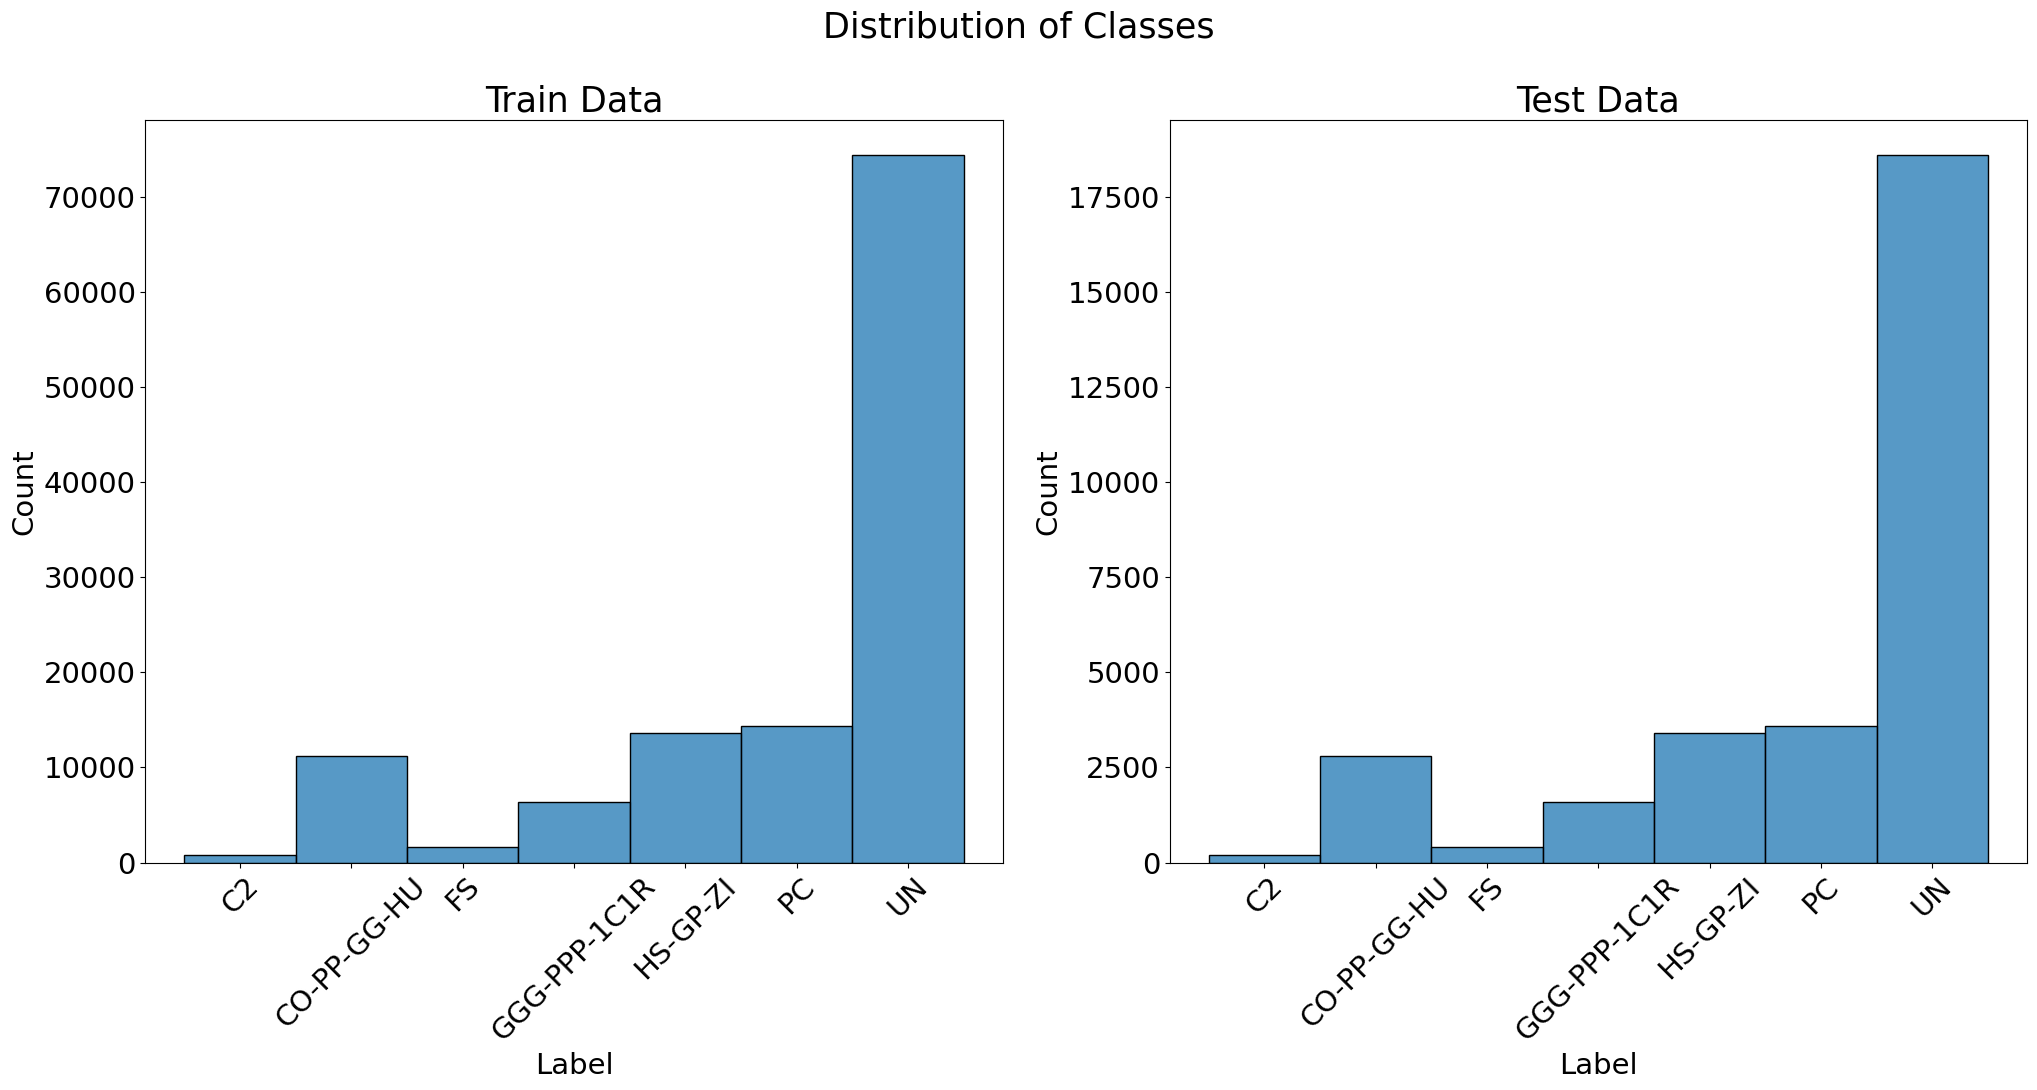

In [123]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2080*px,1124*px))

fig.suptitle("Distribution of Classes")
ax1.set_title("Train Data")
ax2.set_title("Test Data")
sns.histplot(data=y_train.sort_values(),ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_xlabel("Label")
sns.histplot(data=y_test.sort_values(),ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_xlabel("Label")

fig.tight_layout()
fig.savefig("class_distribution.svg", format="svg", dpi=1200)

### Instantiate PCA models

In [27]:
pca_LR = PCA()
pca = PCA()
pca_pLR = PCA()
pca_p = PCA()
scores_LR = pca_LR.fit_transform(x_train_LR)
scores = pca.fit_transform(x_train)
scores_pLR = pca_pLR.fit_transform(px_train_LR)
scores_p = pca_p.fit_transform(px_train)

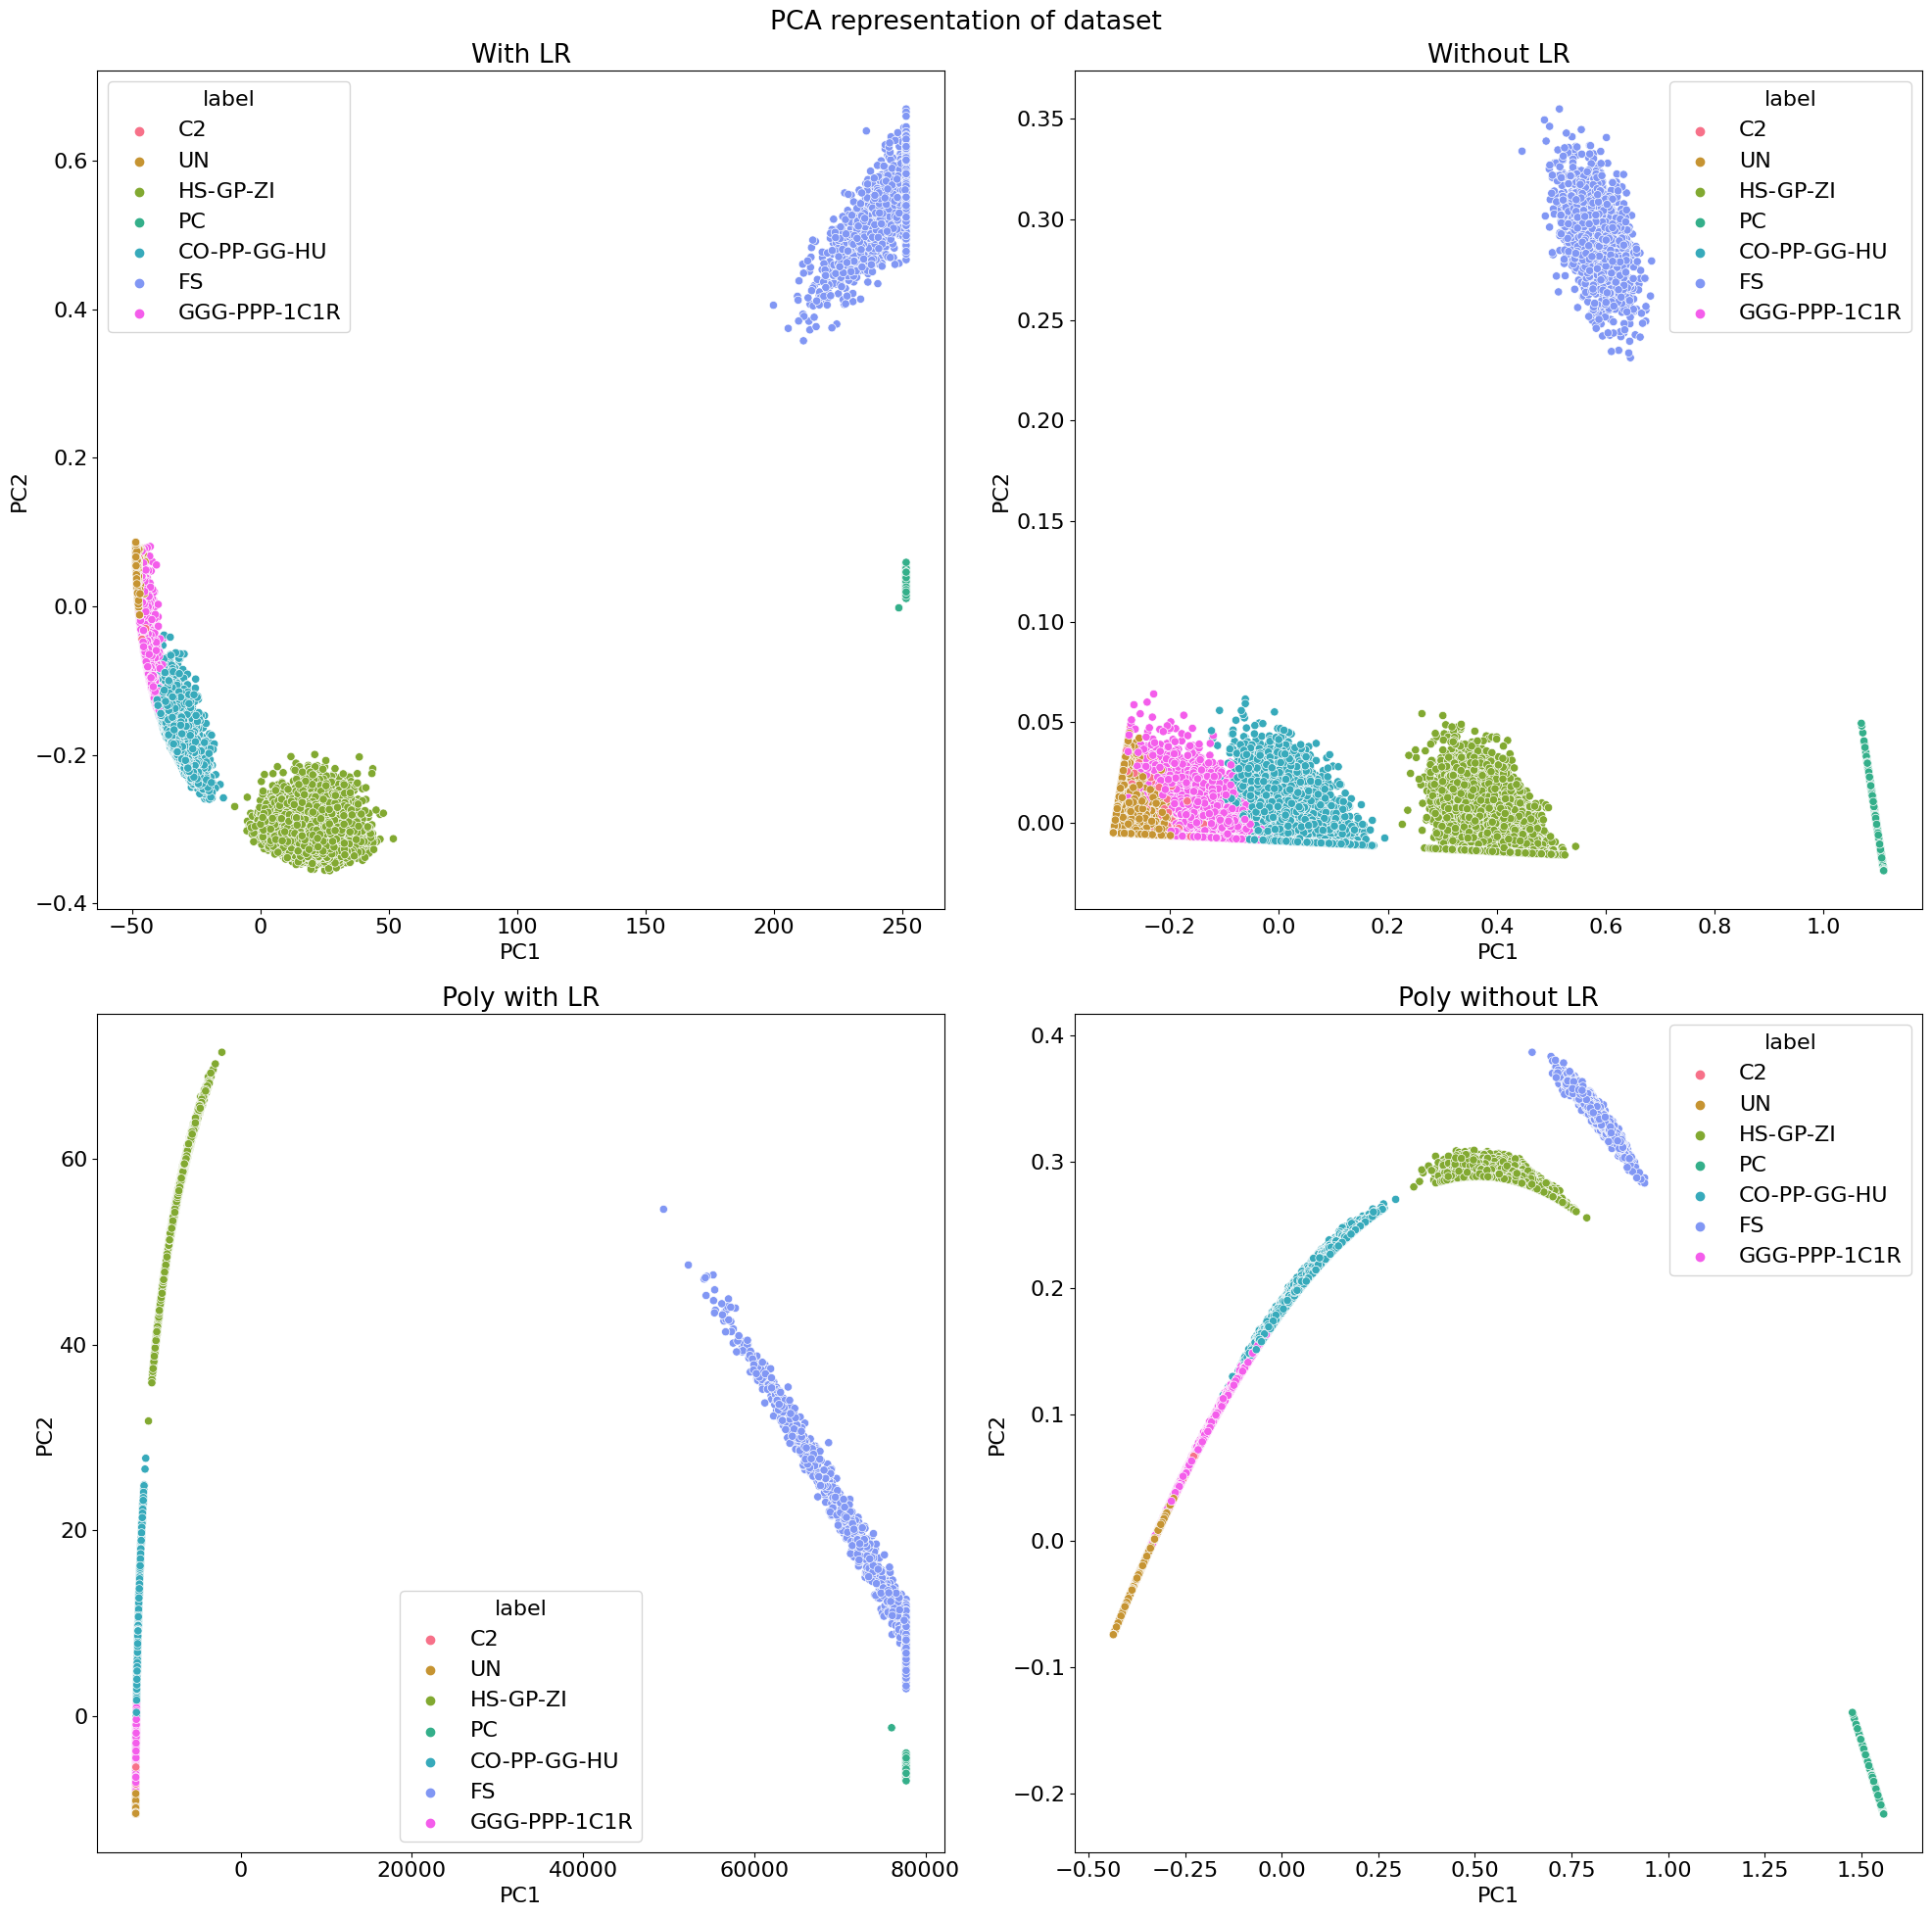

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax1, ax2,ax3,ax4 = axes.ravel()
fig.suptitle("PCA representation of dataset")
palette = sns.color_palette("husl", 7)
sns.scatterplot(
    x=scores_LR[:, 0], y=scores_LR[:, 1], hue=y_train, ax=ax1, palette=palette,
)
ax1.set_title("With LR")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

sns.scatterplot(x=scores[:, 0], y=scores[:, 1], hue=y_train, ax=ax2, palette=palette)
ax2.set_title("Without LR")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
sns.scatterplot(
    x=scores_pLR[:, 0], y=scores_pLR[:, 1], hue=y_train, ax=ax3, palette=palette,
)
ax3.set_title("Poly with LR")
ax3.set_xlabel("PC1")
ax3.set_ylabel("PC2")

sns.scatterplot(x=scores_p[:, 0], y=scores_p[:, 1], hue=y_train, ax=ax4, palette=palette)
ax4.set_title("Poly without LR")
ax4.set_xlabel("PC1")
ax4.set_ylabel("PC2")
fig.tight_layout()

## Classification


### LinearSVC


In [ ]:
linear_clf_LR = LinearSVC()
linear_clf = LinearSVC()
linear_clf_pLR = LinearSVC()
linear_clf_p = LinearSVC()

y_pred_LR = cross_val_predict(linear_clf_LR, X=scaled_x_train_LR, y=y_train, n_jobs=10)
y_pred = cross_val_predict(linear_clf, X=scaled_x_train, y=y_train, n_jobs=10)
y_pred_pLR = cross_val_predict(linear_clf_pLR, X=scaled_px_train_LR, y=y_train, n_jobs=10)
y_pred_p = cross_val_predict(linear_clf_p, X=scaled_px_train, y=y_train, n_jobs=10)


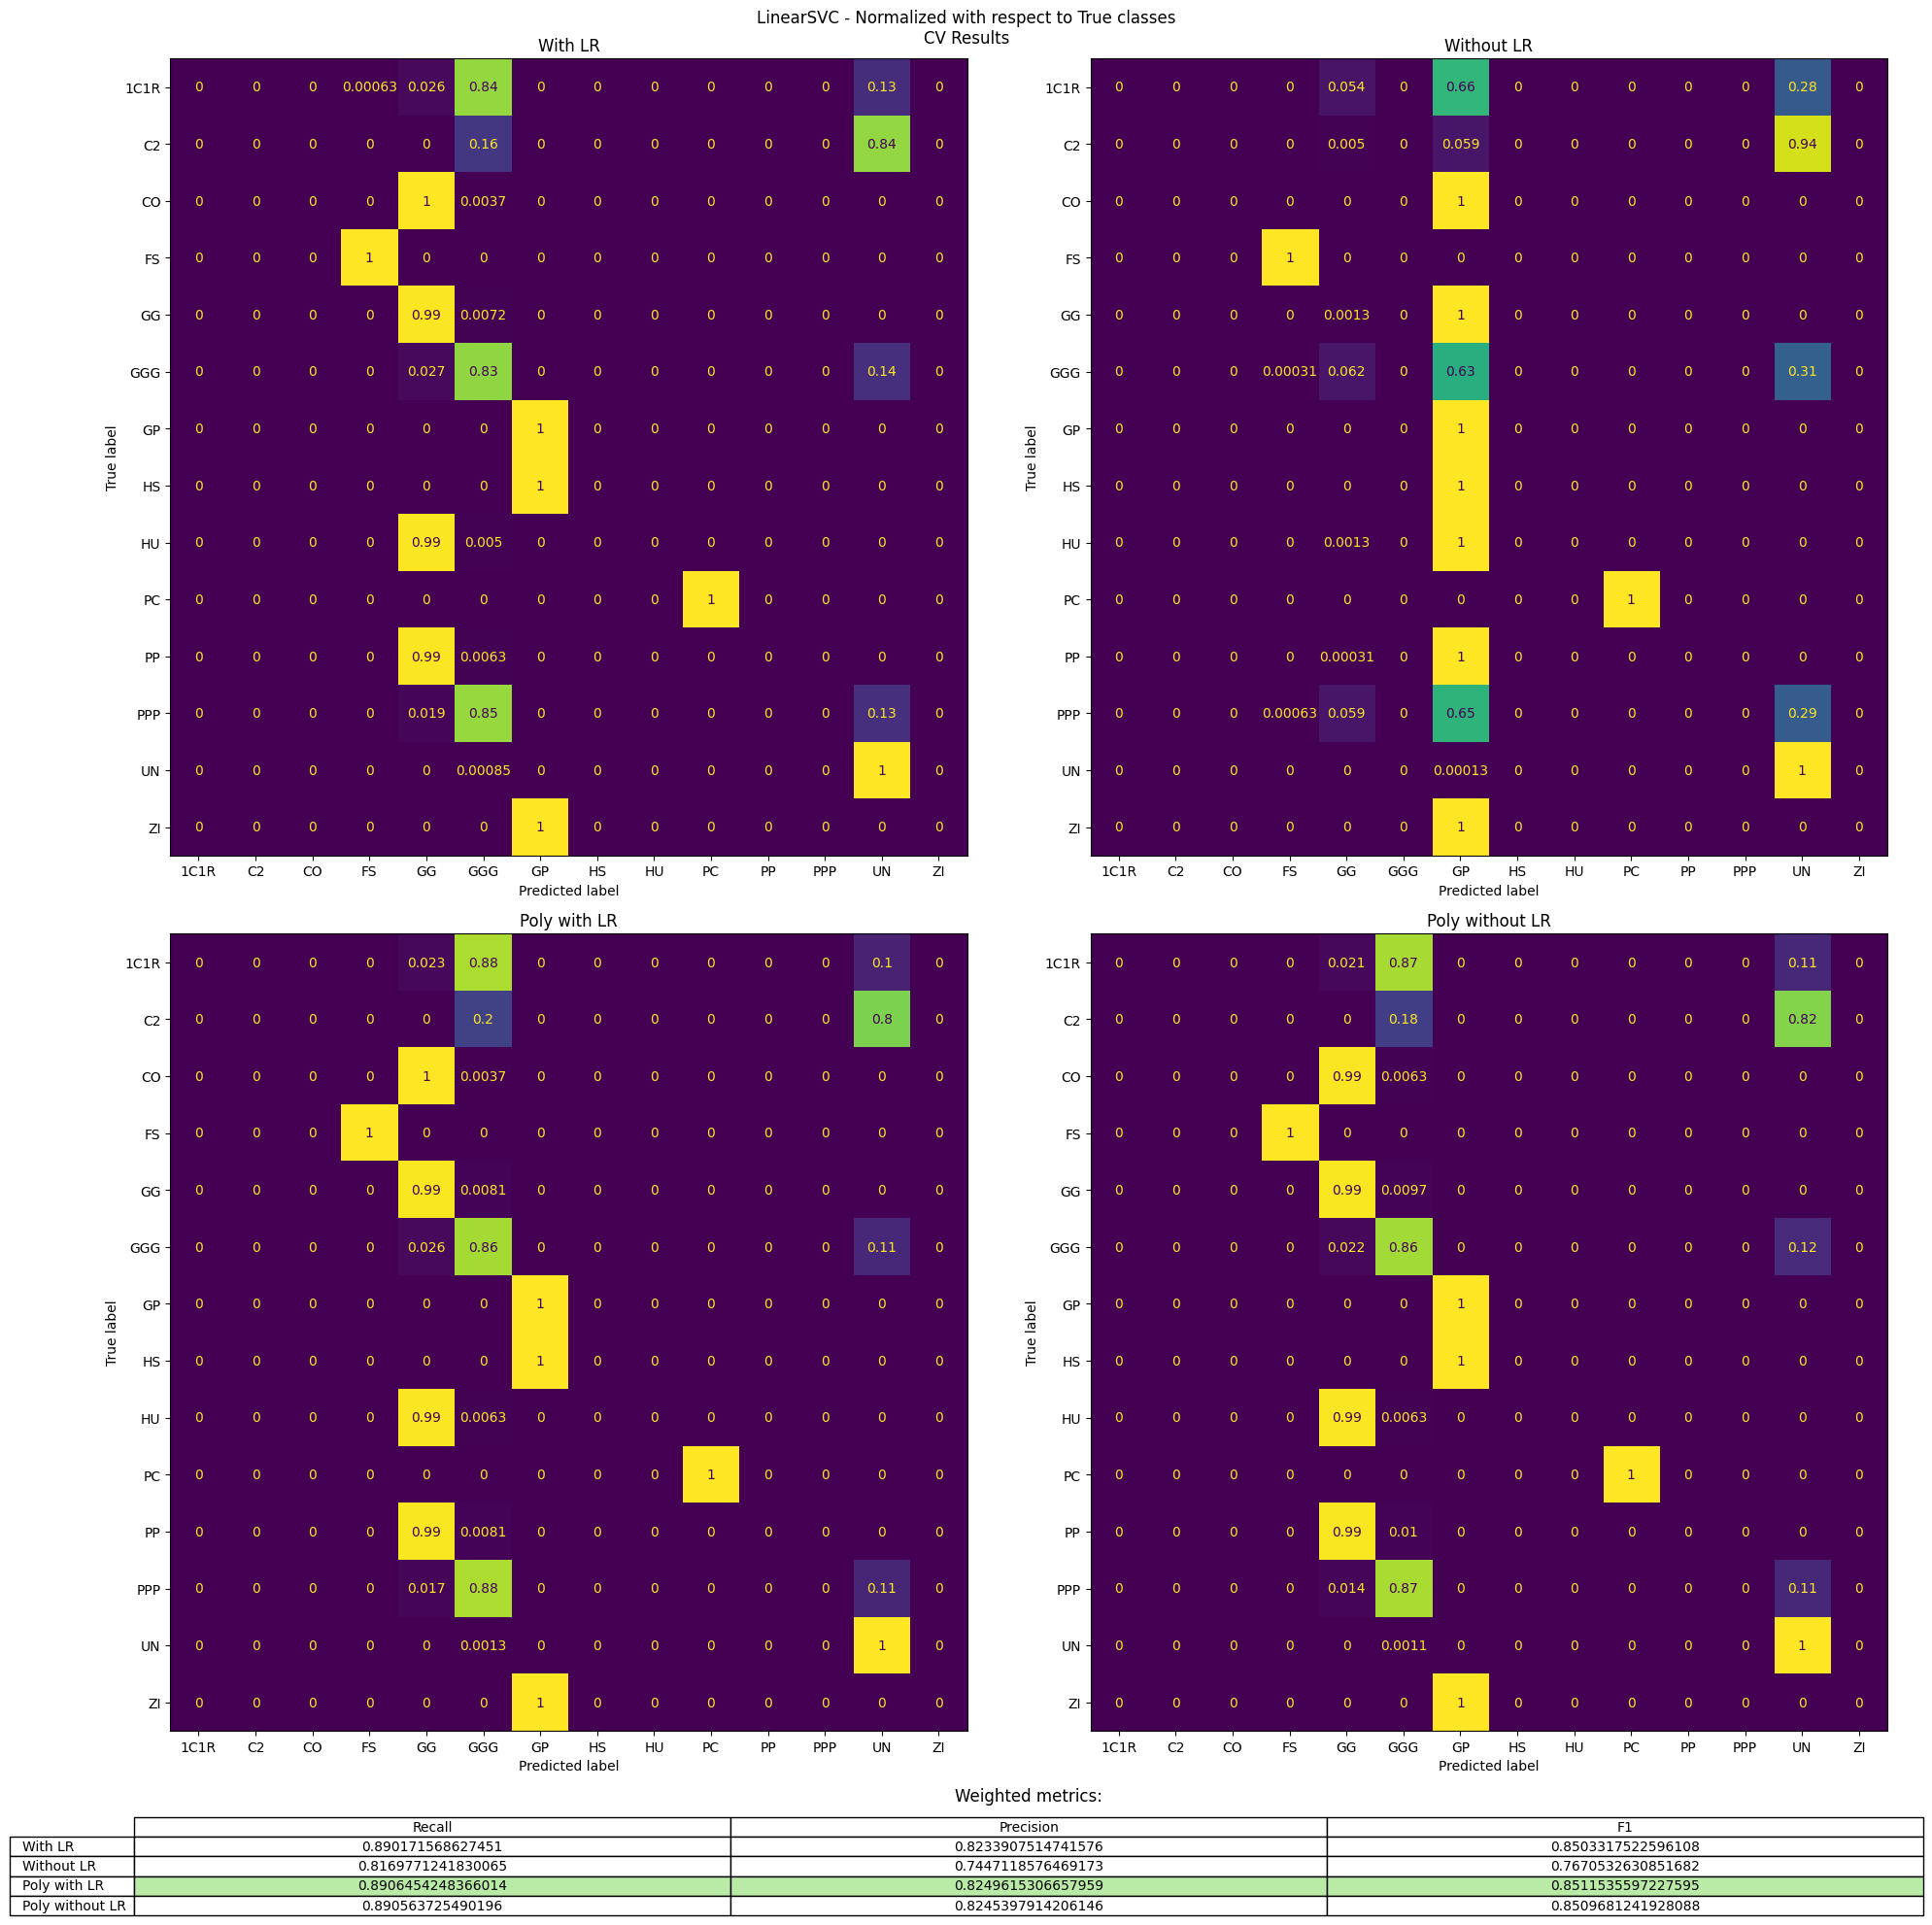

In [80]:
fig = CM_report(
    y_true=y_train,
    y_pred=[y_pred_LR, y_pred, y_pred_pLR, y_pred_p],
    title="LinearSVC - Normalized with respect to True classes\nCV Results",
    experiment_names=["With LR", "Without LR", "Poly with LR", "Poly without LR"],
)


### SGDClassifier (hinge like SVM)

In [88]:
sgd_clf_LR = SGDClassifier(
    fit_intercept=False,
    class_weight="balanced",
    early_stopping=True,
    n_jobs=5,
)
sgd_clf = SGDClassifier(
    fit_intercept=False,
    class_weight="balanced",
    early_stopping=True,
    n_jobs=5,
)
sgd_clf_pLR = SGDClassifier(
    fit_intercept=False,
    class_weight="balanced",
    early_stopping=True,
    n_jobs=5,
)
sgd_clf_p = SGDClassifier(
    fit_intercept=False,
    class_weight="balanced",
    early_stopping=True,
    n_jobs=5,
)


In [89]:
param_grid = {
    "eta0": [1, 0.1, 0.01, 0.001],
    "learning_rate": ["adaptive"],
    "alpha": [0.01, 0.001, 0.0001]
}

hgs_sgd_LR = HalvingGridSearchCV(sgd_clf_LR, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")
hgs_sgd = HalvingGridSearchCV(sgd_clf, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")
hgs_sgd_pLR = HalvingGridSearchCV(sgd_clf_pLR, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")
hgs_sgd_p = HalvingGridSearchCV(sgd_clf_p, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")

hgs_sgd_LR.fit(scaled_x_train_LR, y_train)
hgs_sgd.fit(scaled_x_train, y_train)
hgs_sgd_pLR.fit(scaled_px_train_LR, y_train)
hgs_sgd_p.fit(scaled_px_train, y_train)


print(hgs_sgd_LR.best_params_)
print(hgs_sgd.best_params_)
print(hgs_sgd_pLR.best_params_)
print(hgs_sgd_p.best_params_)

{'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive'}
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'adaptive'}
{'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'adaptive'}
{'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive'}


In [15]:
y_pred_LR = cross_val_predict(hgs_sgd_LR.best_estimator_, X=scaled_x_train_LR, y=y_train, n_jobs=2)
y_pred = cross_val_predict(hgs_sgd.best_estimator_, X=scaled_x_train, y=y_train, n_jobs=2)
y_pred_pLR = cross_val_predict(hgs_sgd_pLR.best_estimator_, X=scaled_px_train_LR, y=y_train, n_jobs=2)
y_pred_p = cross_val_predict(hgs_sgd_p.best_estimator_, X=scaled_px_train, y=y_train, n_jobs=2)


In [69]:
y_pred_LR = hgs_sgd_LR.best_estimator_.predict(scaled_x_test_LR)
y_pred = hgs_sgd.best_estimator_.predict(scaled_x_test)
y_pred_pLR =hgs_sgd_pLR.best_estimator_.predict(scaled_px_test_LR)
y_pred_p = hgs_sgd_p.best_estimator_.predict(scaled_px_test)

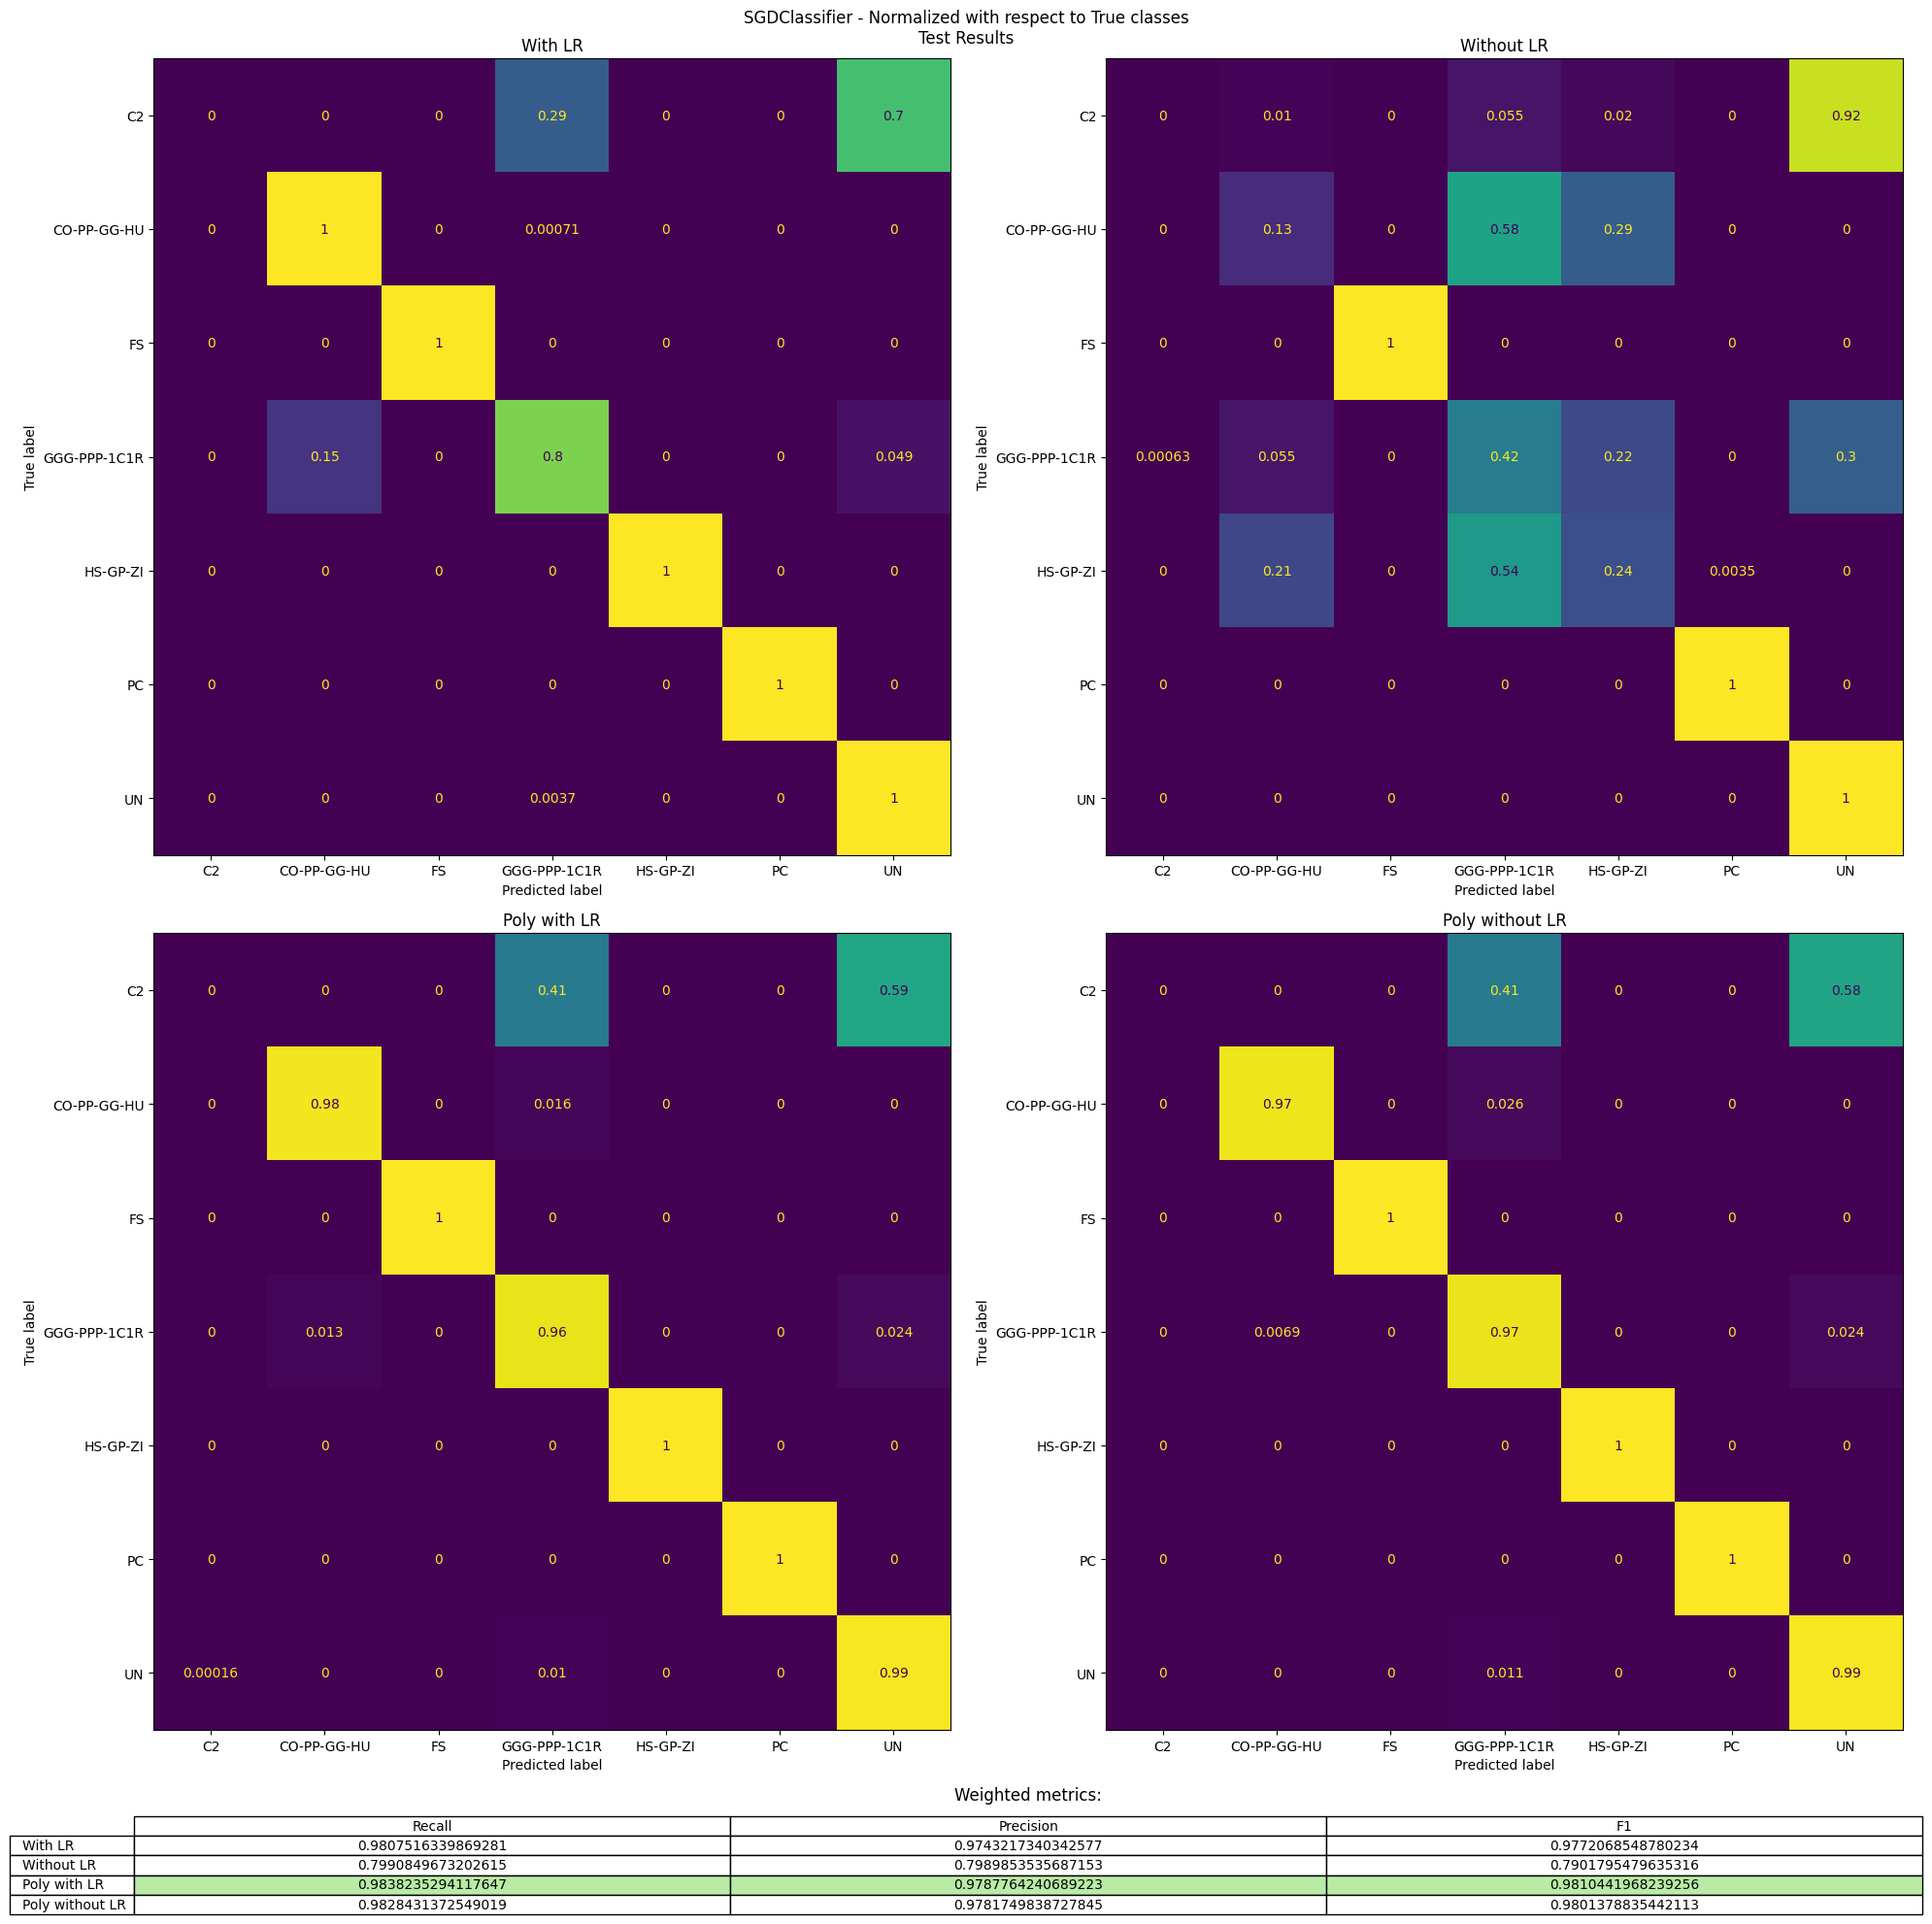

In [71]:
fig = CM_report(
    y_true=y_test,
    y_pred=[y_pred_LR, y_pred, y_pred_pLR, y_pred_p],
    title="SGDClassifier - Normalized with respect to True classes\nTest Results",
    experiment_names=["With LR", "Without LR", "Poly with LR", "Poly without LR"],
)


In [ ]:
sgd_clf_LR.fit(scaled_x_train_LR)
sgd_clf.fit(scaled_x_train)
sgd_clf_pLR.fit(scaled_px_train_LR)
sgd_clf_p.fit(scaled_px_train)

### Random Forest


In [11]:
rf_clf_LR = RandomForestClassifier(
    n_jobs=5, class_weight="balanced"
)
rf_clf = RandomForestClassifier(
    n_jobs=5, class_weight="balanced"
)
rf_clf_pLR = RandomForestClassifier(
    n_jobs=5, class_weight="balanced"
)
rf_clf_p = RandomForestClassifier(
   n_jobs=5, class_weight="balanced"
)


In [12]:
param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [2,3,4]
}

hgs_rf_LR = HalvingGridSearchCV(rf_clf_LR, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")
hgs_rf = HalvingGridSearchCV(rf_clf, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")
hgs_rf_pLR = HalvingGridSearchCV(rf_clf_pLR, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")
hgs_rf_p = HalvingGridSearchCV(rf_clf_p, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")

hgs_rf_LR.fit(scaled_x_train_LR, y_train)
hgs_rf.fit(scaled_x_train, y_train)
hgs_rf_pLR.fit(scaled_px_train_LR, y_train)
hgs_rf_p.fit(scaled_px_train, y_train)


print(hgs_rf_LR.best_params_)
print(hgs_rf.best_params_)
print(hgs_rf_pLR.best_params_)
print(hgs_rf_p.best_params_)

{'max_depth': 2, 'n_estimators': 200}
{'max_depth': 4, 'n_estimators': 500}
{'max_depth': 3, 'n_estimators': 300}
{'max_depth': 3, 'n_estimators': 200}


In [18]:
hgs_rf_LR = HalvingGridSearchCV(rf_clf_LR, param_grid=param_grid, n_jobs=2, scoring="recall_weighted")
hgs_rf_LR.fit(scaled_x_train_LR, y_train)
print(hgs_rf_LR.best_params_)

{'max_depth': 3, 'n_estimators': 300}


In [19]:
y_pred_LR = cross_val_predict(hgs_rf_LR.best_estimator_, X=x_train_LR, y=y_train, n_jobs=5)
y_pred = cross_val_predict(hgs_rf.best_estimator_, X=x_train, y=y_train, n_jobs=5)
y_pred_pLR = cross_val_predict(hgs_rf_pLR.best_estimator_, X=px_train_LR, y=y_train, n_jobs=5)
y_pred_p = cross_val_predict(hgs_rf_p.best_estimator_, X=px_train, y=y_train, n_jobs=5)


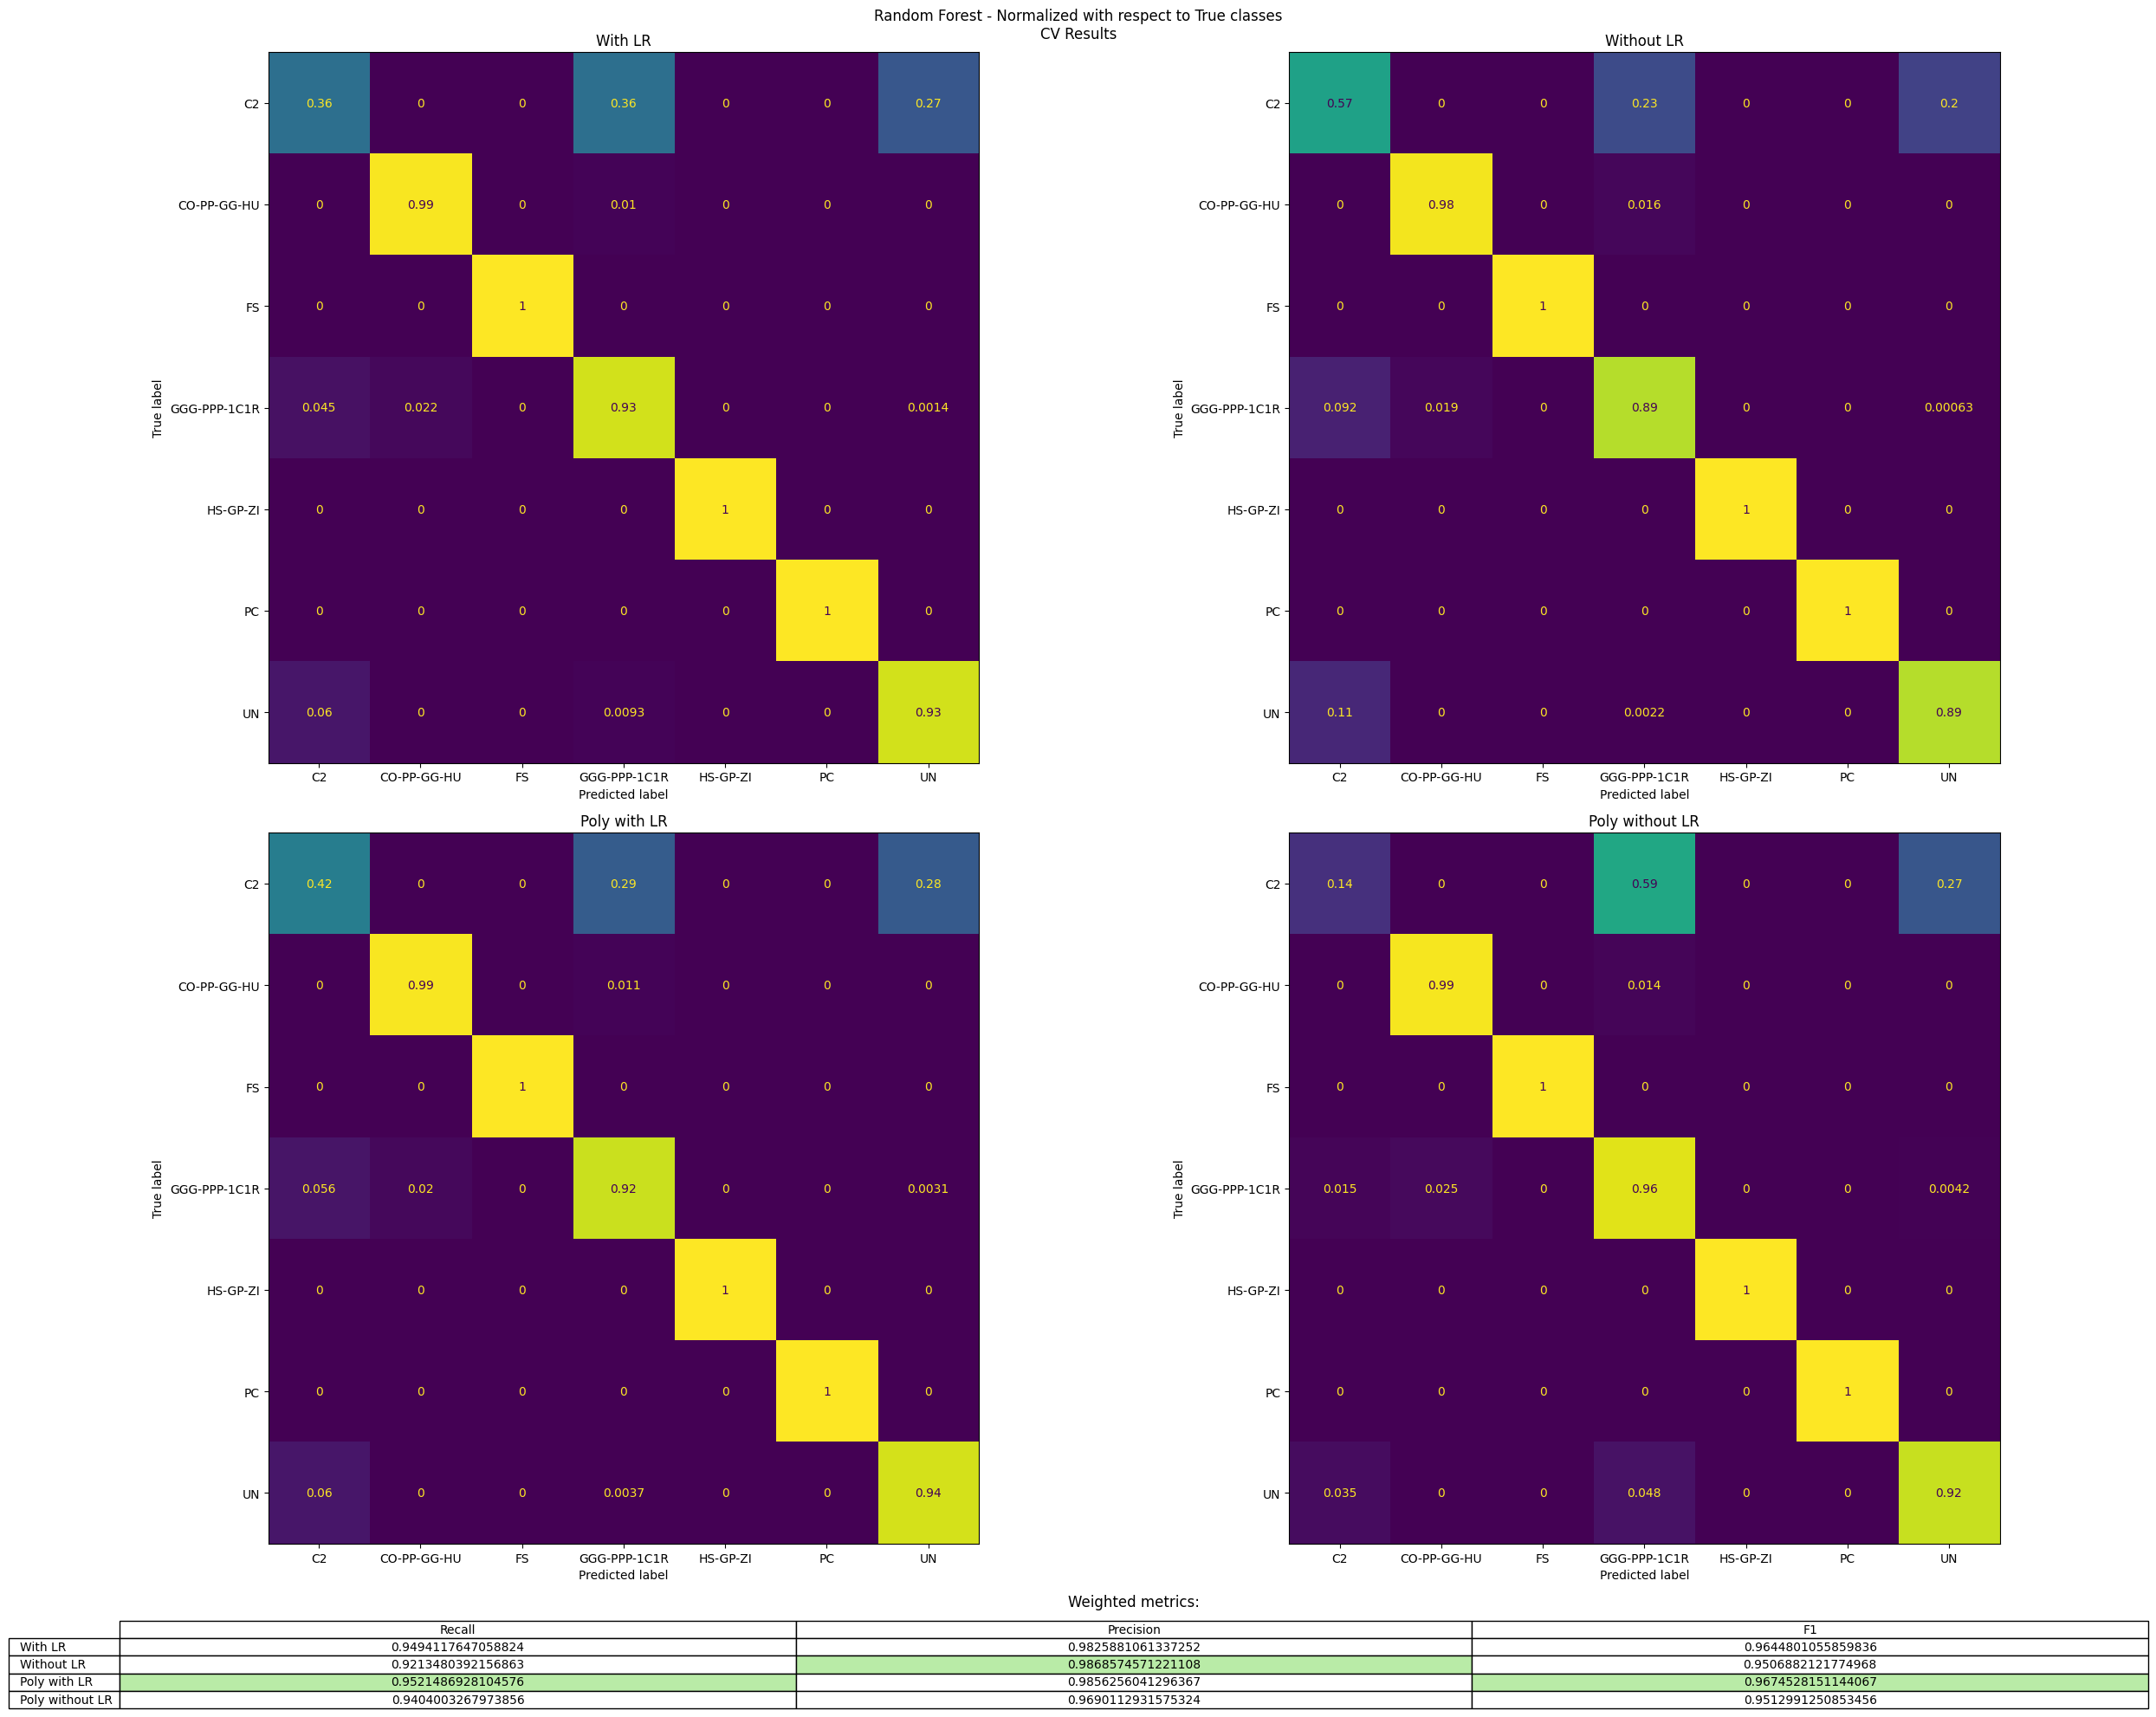

In [20]:
fig = CM_report(
    y_true=y_train,
    y_pred=[y_pred_LR, y_pred, y_pred_pLR, y_pred_p],
    title="Random Forest - Normalized with respect to True classes\nCV Results",
    experiment_names=["With LR", "Without LR", "Poly with LR", "Poly without LR"],
)


In [21]:
y_pred_LR_t = hgs_rf_LR.best_estimator_.predict(scaled_x_test_LR)
y_pred_t = hgs_rf.best_estimator_.predict(scaled_x_test)
y_pred_pLR_t =hgs_rf_pLR.best_estimator_.predict(scaled_px_test_LR)
y_pred_p_t = hgs_rf_p.best_estimator_.predict(scaled_px_test)

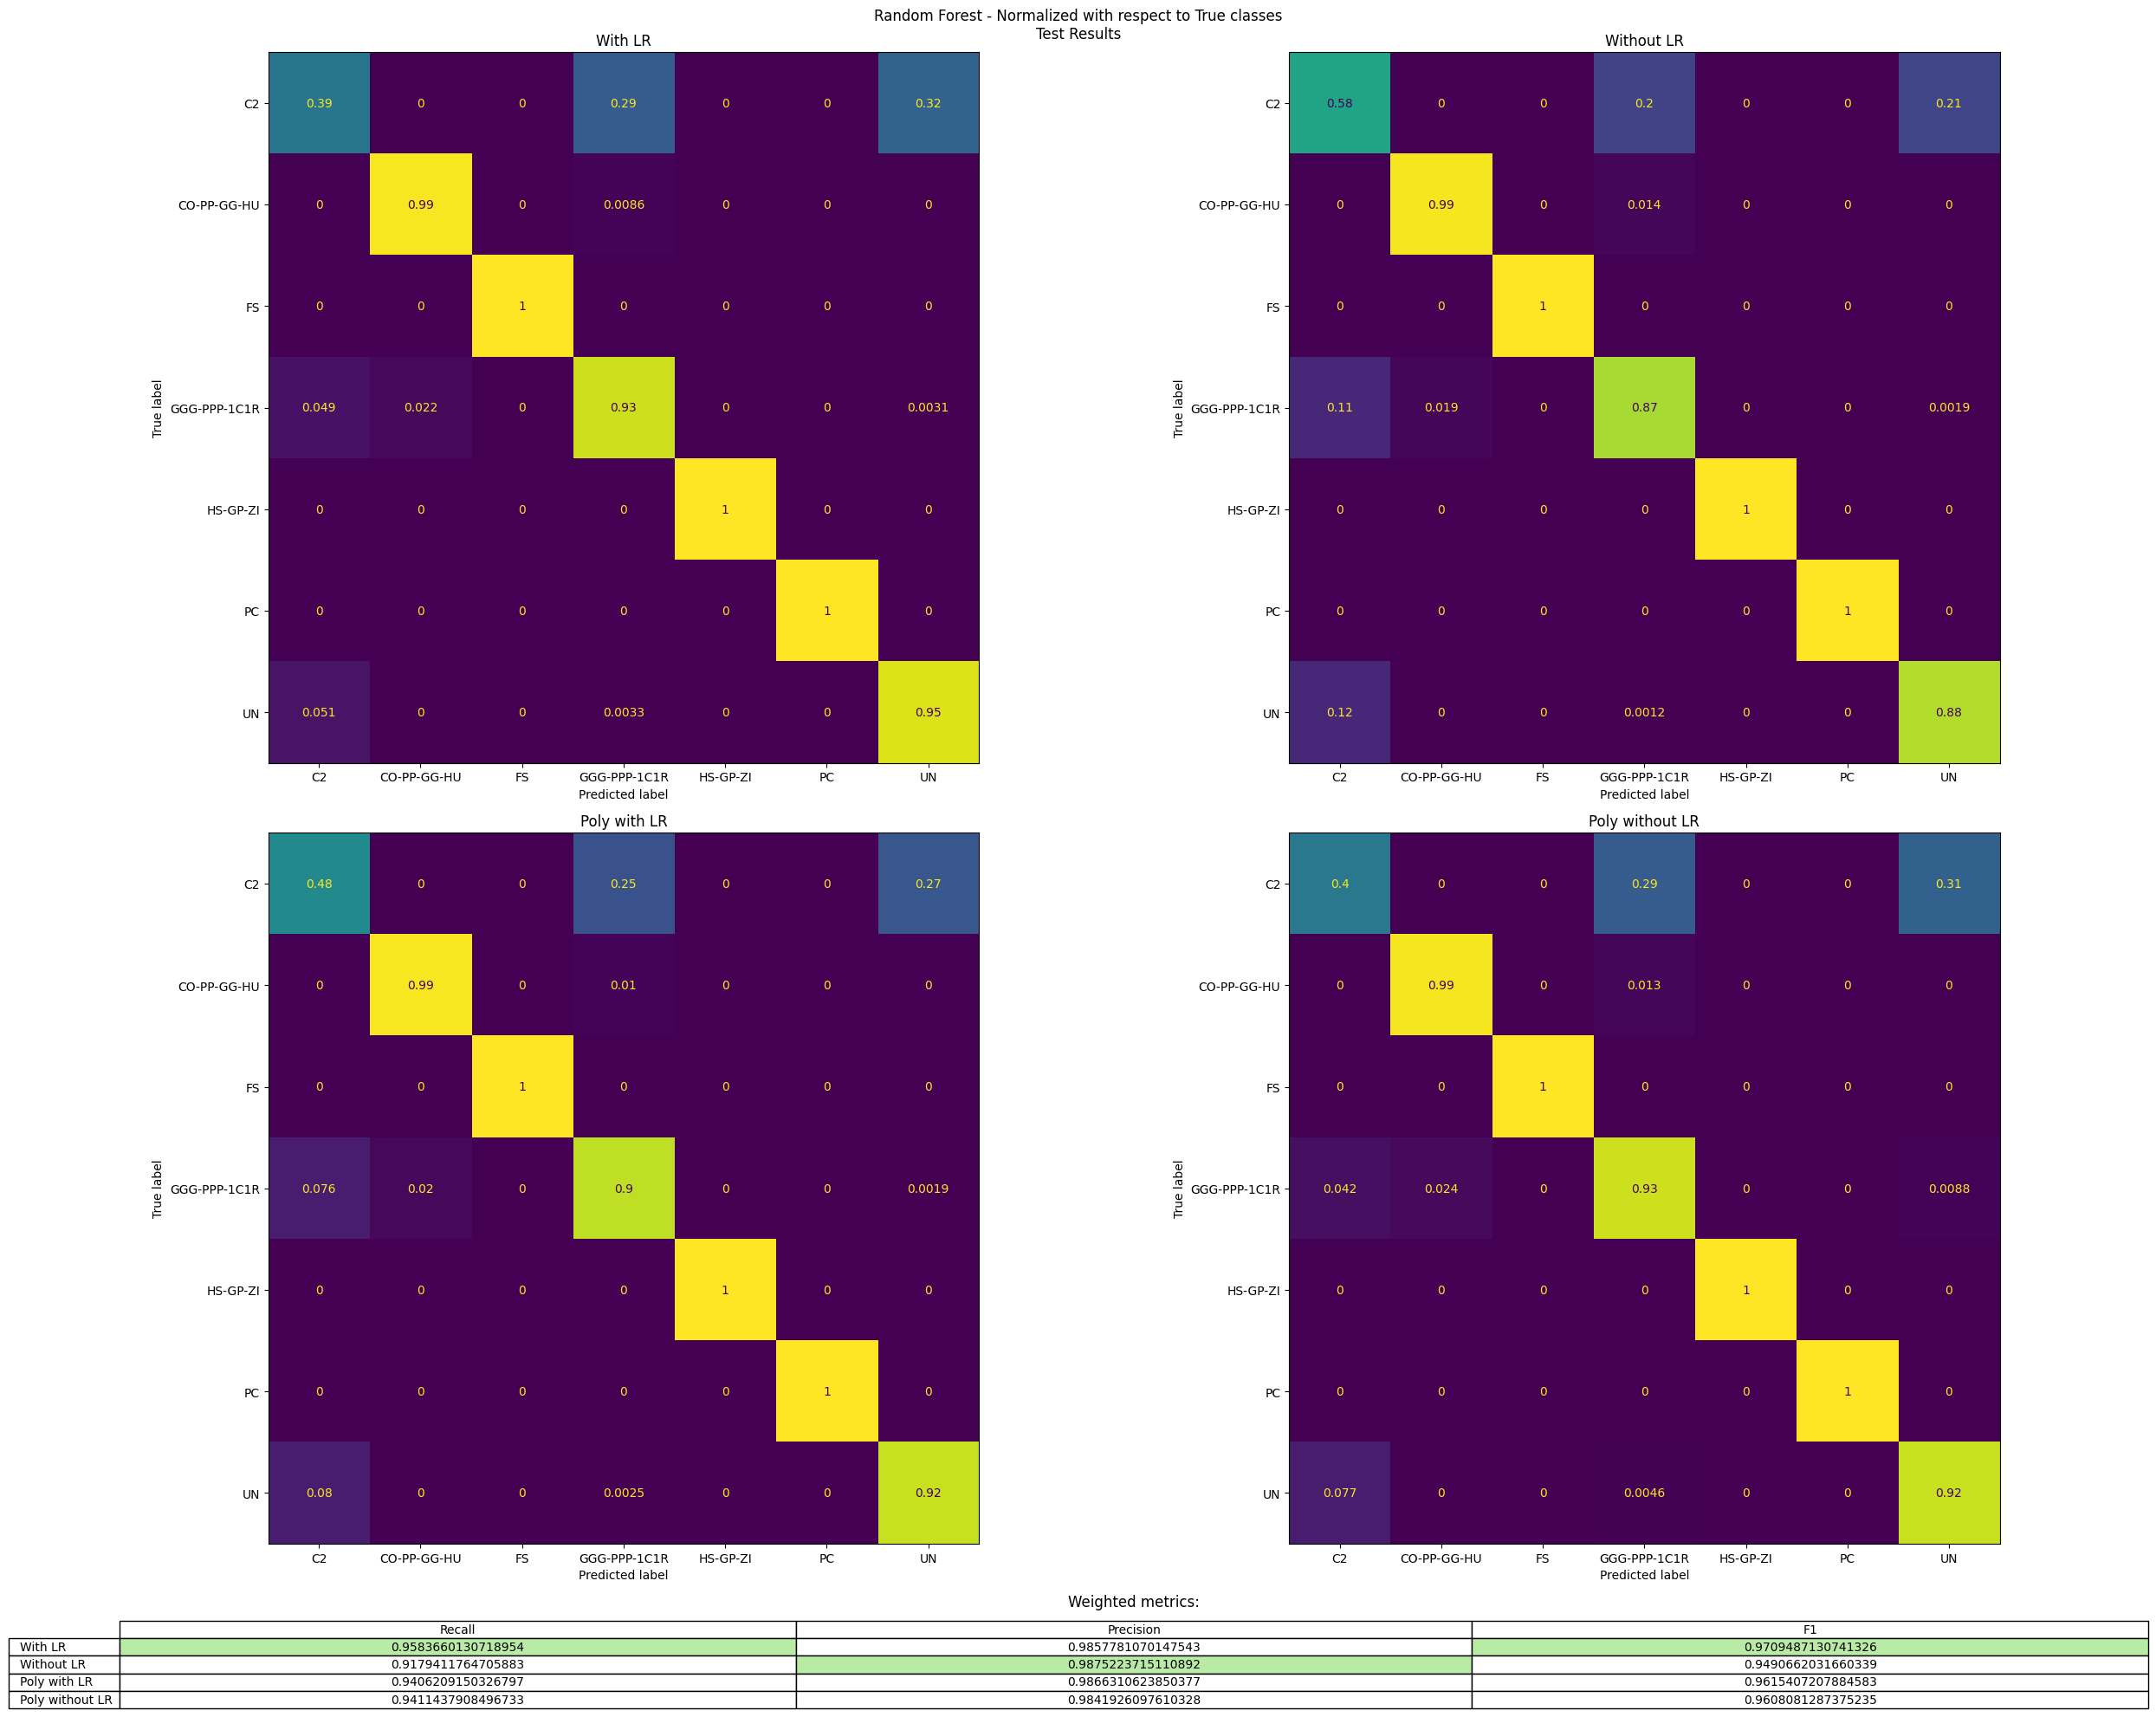

In [22]:
fig = CM_report(
    y_true=y_test,
    y_pred=[y_pred_LR_t, y_pred_t, y_pred_pLR_t, y_pred_p_t],
    title="Random Forest - Normalized with respect to True classes\nTest Results",
    experiment_names=["With LR", "Without LR", "Poly with LR", "Poly without LR"],
)


#### Export for article

In [ ]:
from joblib import dump, load

dump(hgs_rf_LR.best_estimator_, 'best_rf_model.joblib')

In [100]:
from joblib import load

rf_model = load("best_rf_model.joblib")

In [55]:
y_pred_test = rf_model.predict(scaled_x_test_LR)
y_pred = cross_val_predict(rf_model, X=x_train, y=y_train, n_jobs=5)


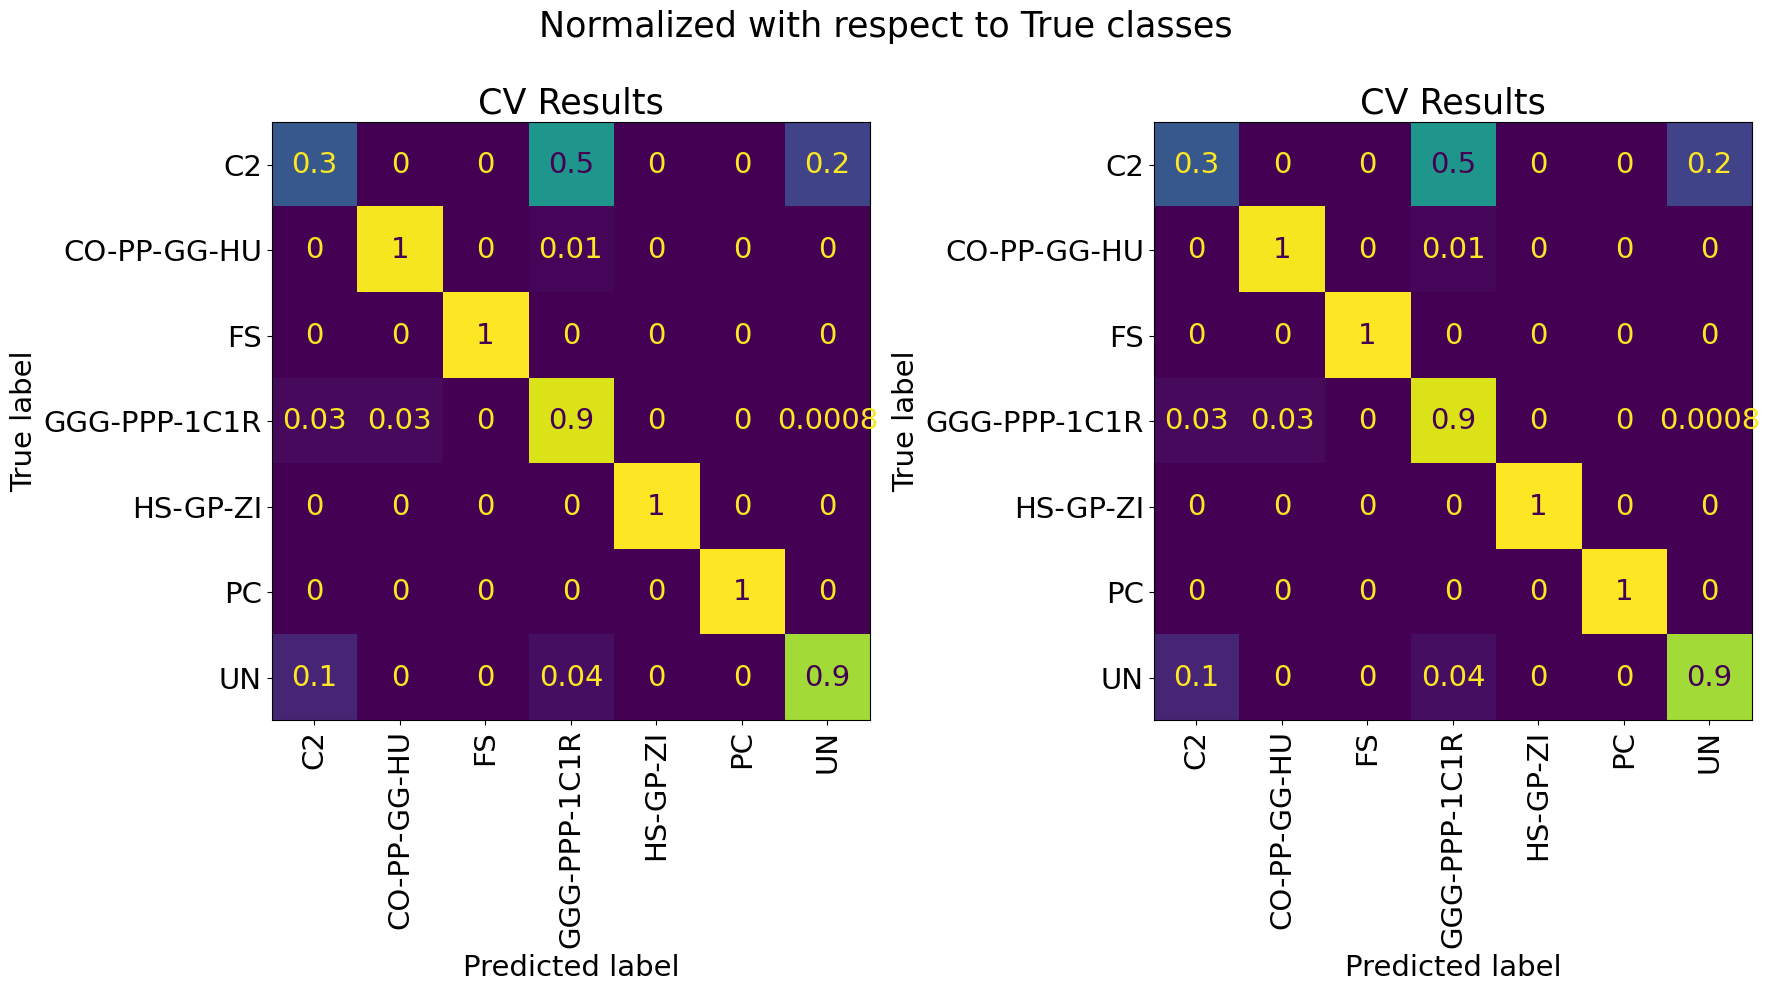

In [129]:
fig = CM_report(y_train, [y_pred, y_pred], experiment_names=["CV Results","CV Results"], title="Normalized with respect to True classes");
fig.savefig("confusion_matrix_cv.svg", format="svg", dpi=1200)


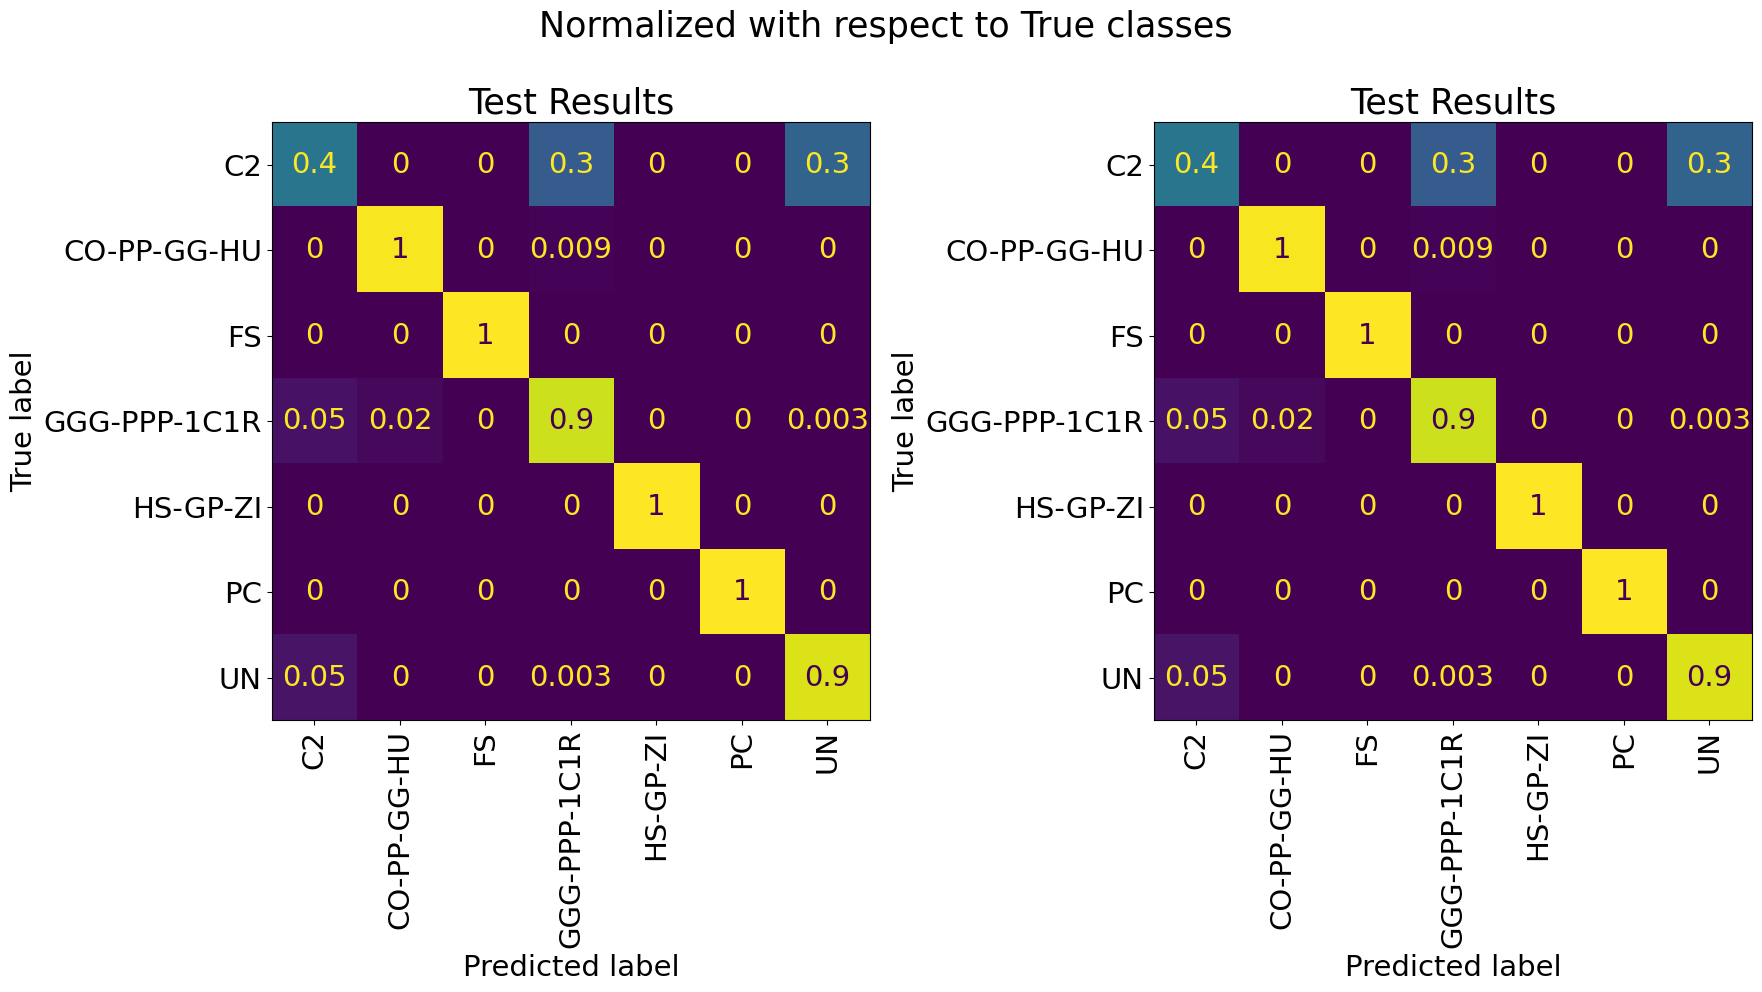

In [130]:
fig = CM_report(y_test, [y_pred_test, y_pred_test], experiment_names=["Test Results","Test Results"], title="Normalized with respect to True classes");
fig.savefig("confusion_matrix_test.svg", format="svg", dpi=1200)


In [26]:
pd.DataFrame(
    classification_report(
        y_test,
        y_pred_test,
        labels=rf_model.classes_,
        output_dict=True,
        digits=5,
    )
)


,C2,CO-PP-GG-HU,FS,GGG-PPP-1C1R,HS-GP-ZI,PC,UN,accuracy,macro avg,weighted avg
precision,0.070652,0.987549,1.0,0.911385,1.0,1.0,0.996093,0.958366,0.852240,0.985778
recall,0.390000,0.991429,1.0,0.925625,1.0,1.0,0.945753,0.958366,0.893258,0.958366
f1-score,0.119632,0.989485,1.0,0.918450,1.0,1.0,0.970270,0.958366,0.856834,0.970949
support,200.000000,2800.000000,400.0,1600.000000,3400.0,3600.0,18600.000000,0.958366,30600.000000,30600.000000


#### Feature importances

In [ ]:
pd.DataFrame(rf_model.best_estimator_.coef_, index=hgs_sgd_pLR.best_estimator_.classes_, columns=poly_features_LR.get_feature_names_out())

In [25]:
ix = np.argsort(hgs_rf_LR.best_estimator_.feature_importances_)[::-1]
list(zip(x_LR.columns[ix], hgs_rf_LR.best_estimator_.feature_importances_[ix]))

[('LR', 0.3588690989921622),
 ('k0', 0.26741805854179107),
 ('k1', 0.2336574667077059),
 ('k2', 0.14005537575834087)]

In [87]:
ix = np.argsort(hgs_rf_LR.best_estimator_.feature_importances_)[::-1]
list(zip(poly_features_LR.feature_names_in_[ix], hgs_rf_LR.best_estimator_.feature_importances_[ix]))

[('LR', 0.3605302311204607),
 ('k0', 0.26813858788613704),
 ('k1', 0.2368522970175783),
 ('k2', 0.13447888397582403)]

#### Improving C2-UN separation

In [28]:
scores_LR = pca_LR.fit_transform(x_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")])

/tmp/ipykernel_150572/3631518174.py:6: UserWarning: The palette list has more values (12) than needed (3), which may not be intended.
  sns.scatterplot(


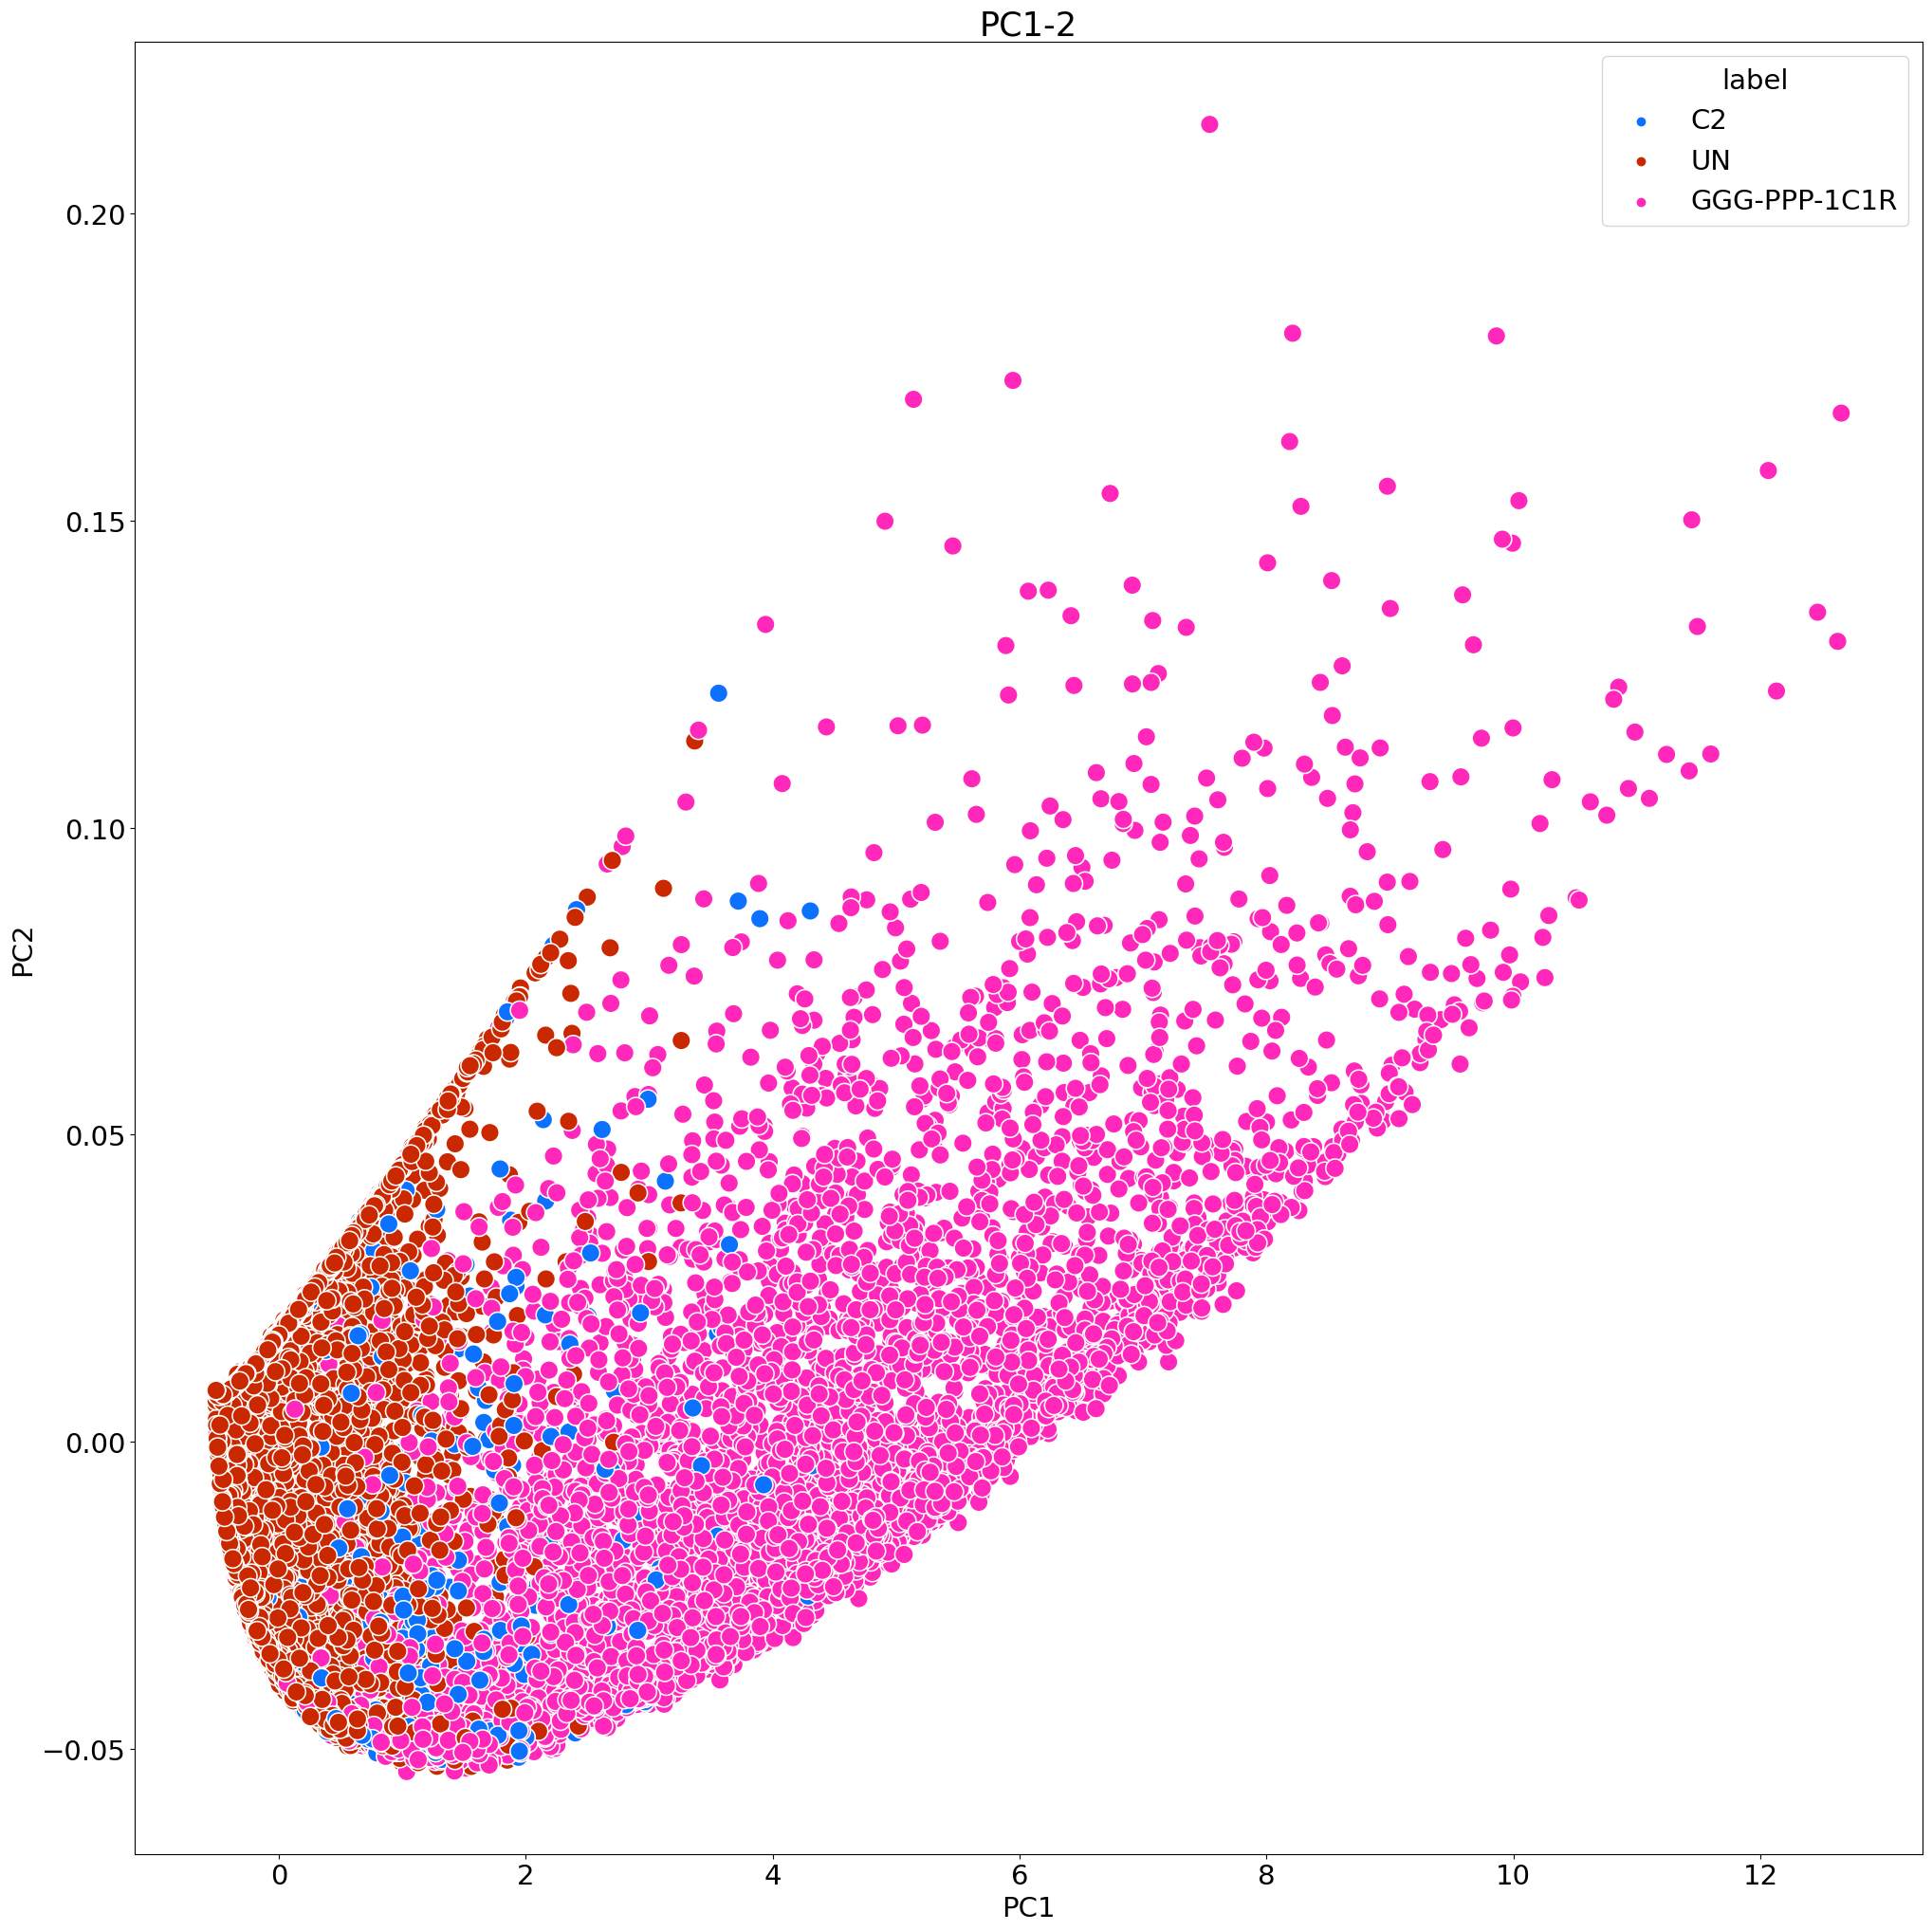

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2080*px, 2080*px))
# ax1, ax2, ax3, ax4 = axs.ravel()

# palette = sns.color_palette("tab10", 3)
palette = glasbey.create_palette(palette_size=12, colorblind_safe=True)
sns.scatterplot(
    x=scores_LR[:, 0], y=scores_LR[:, 1], hue=y_train[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R") ], ax=axs, palette=palette, s=200
)
axs.set_title("PC1-2")
axs.set_xlabel("PC1")
axs.set_ylabel("PC2")

fig.tight_layout()
fig.savefig("separation_colorblind.png", format="png", dpi=1200)

In [92]:
b_logit_clf = LogisticRegression(
    class_weight="balanced", penalty="elasticnet", solver="saga", n_jobs=5
)
b_rf_clf = RandomForestClassifier(max_depth=4, class_weight="balanced", n_jobs=5, n_estimators=500)

b_svc_clf = sgd_clf_LR = SGDClassifier(
    fit_intercept=False,
    class_weight="balanced",
    early_stopping=True,
    n_jobs=5,
)
b_svc_kernel_clf = sgd_clf_LR = SGDClassifier(
    fit_intercept=False,
    class_weight="balanced",
    early_stopping=True,
    n_jobs=5,
)

In [93]:
logit_param_grid = {"C": [1, 0.1, 0.001], "l1_ratio": [0.1, 0.5, 0.7]}
rf_param_grid = {"n_estimators": [100, 200, 300, 500], "max_depth": [2, 3, 4]}
svc_param_grid = {
    "alpha": [0.1, 0.01, 0.001, 0.0001],
}


# hgs_logit_clf = HalvingGridSearchCV(
#     b_logit_clf, param_grid=logit_param_grid, n_jobs=2, scoring="recall_weighted"
# )
hgs_rf_clf = HalvingGridSearchCV(
    b_rf_clf, param_grid=rf_param_grid, n_jobs=2, scoring="recall_weighted"
)
# hgs_svc_clf = HalvingGridSearchCV(
#     b_svc_clf, param_grid=svc_param_grid, n_jobs=2, scoring="recall_weighted"
# )
# hgs_svc_kernel_clf = HalvingGridSearchCV(
#     b_svc_kernel_clf, param_grid=svc_param_grid, n_jobs=2, scoring="recall_weighted"
# )

# hgs_logit_clf.fit(
#     X=scaled_x_train_LR[
#         (y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")
#     ],
#     y=y_train[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")],
# )
hgs_rf_clf.fit(
    X=scaled_x_train_LR[
        (y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")
    ],
    y=y_train[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")],
)
# hgs_svc_clf.fit(
#     X=scaled_x_train_LR[
#         (y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")
#     ],
#     y=y_train[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")],
# )
# hgs_svc_kernel_clf.fit(
#     X=scaled_px_train_LR[
#         (y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")
#     ],
#     y=y_train[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")],
# )


# print(hgs_logit_clf.best_params_)
print(hgs_rf_clf.best_params_)
# print(hgs_svc_clf.best_params_)
# print(hgs_svc_kernel_clf.best_params_)


{'max_depth': 4, 'n_estimators': 500}


In [104]:
b_rf_clf.fit(
    X=scaled_x_train_LR[
        (y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")
    ],
    y=y_train[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")],
)


RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                       n_jobs=5)

In [94]:
# y_logit_pred = cross_val_predict(
#     hgs_logit_clf.best_estimator_, X=scaled_x_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")]
# )
y_rf_pred = cross_val_predict(
   b_rf_clf, X=scaled_x_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")]
)
# y_svc_pred = cross_val_predict(
#     hgs_svc_clf.best_estimator_, X=scaled_x_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")]
# )
# y_svc_kernel_pred = cross_val_predict(
#     hgs_svc_kernel_clf.best_estimator_, X=scaled_px_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")]
# )

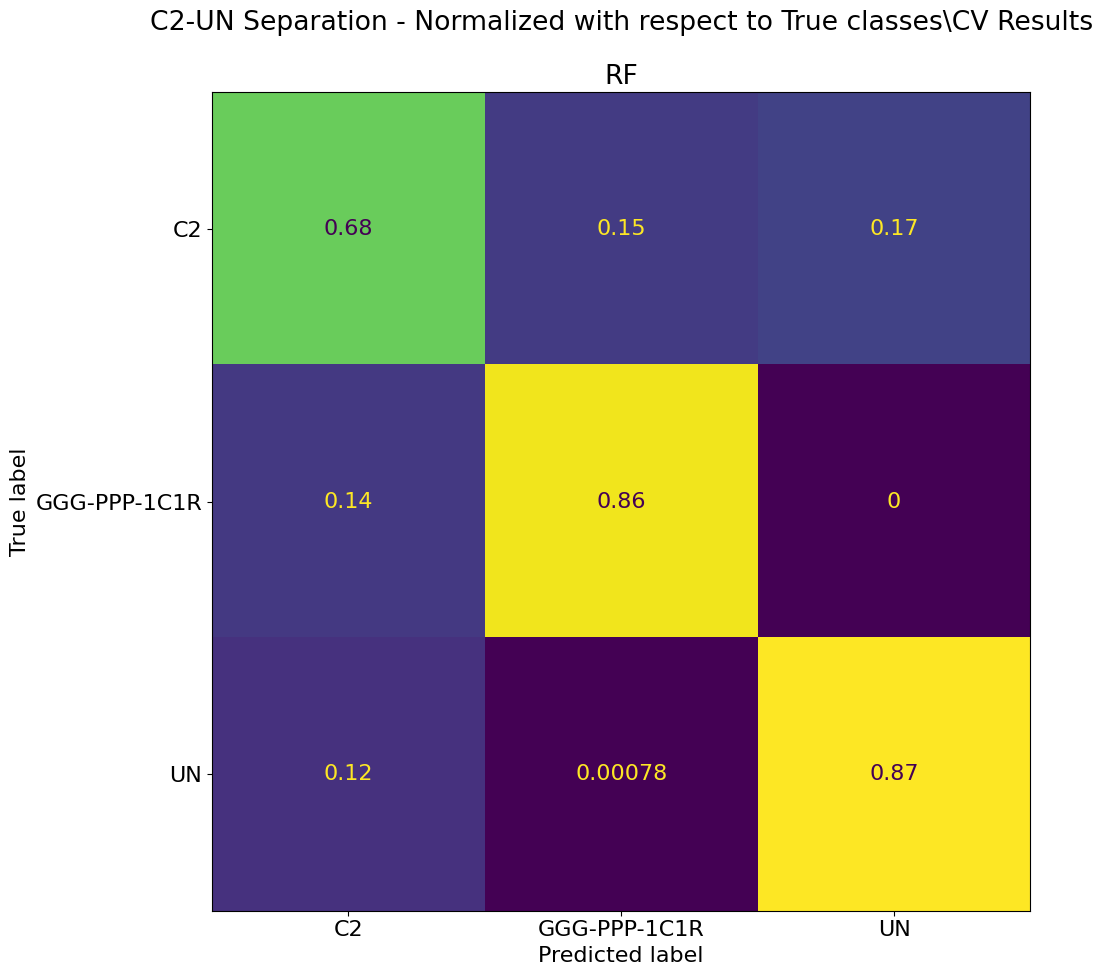

In [58]:
fig = CM_report(
    y_true=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")],
    y_pred=[y_rf_pred],
    title="C2-UN Separation - Normalized with respect to True classes\CV Results",
    experiment_names=["RF"],
)

In [95]:
class CompositePredicter():
    def __init__(self, first_clf, second_clf):
        self.first_clf = first_clf
        self.second_clf = second_clf

    def predict(self, X, y=None):
        first_prediction = self.first_clf.predict(X)
        second_prediction = self.second_clf.predict(X)
        return np.where((first_prediction == "UN") | (first_prediction == "GGG-PPP-1C1R")| (first_prediction == "C2"), second_prediction, first_prediction)

In [102]:
# hgs_logit_clf.best_estimator_.fit(X=scaled_x_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")])
hgs_rf_clf.best_estimator_.fit(X=scaled_x_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")])
# hgs_svc_clf.best_estimator_.fit(X=scaled_x_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")])
# hgs_svc_kernel_clf.best_estimator_.fit(X=scaled_px_train_LR[(y_train == "UN") | (y_train == "C2") | (y_train == "GGG-PPP-1C1R")], y=y_train[(y_train == "UN") | (y_train == "C2")| (y_train == "GGG-PPP-1C1R")])

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                       n_jobs=5)

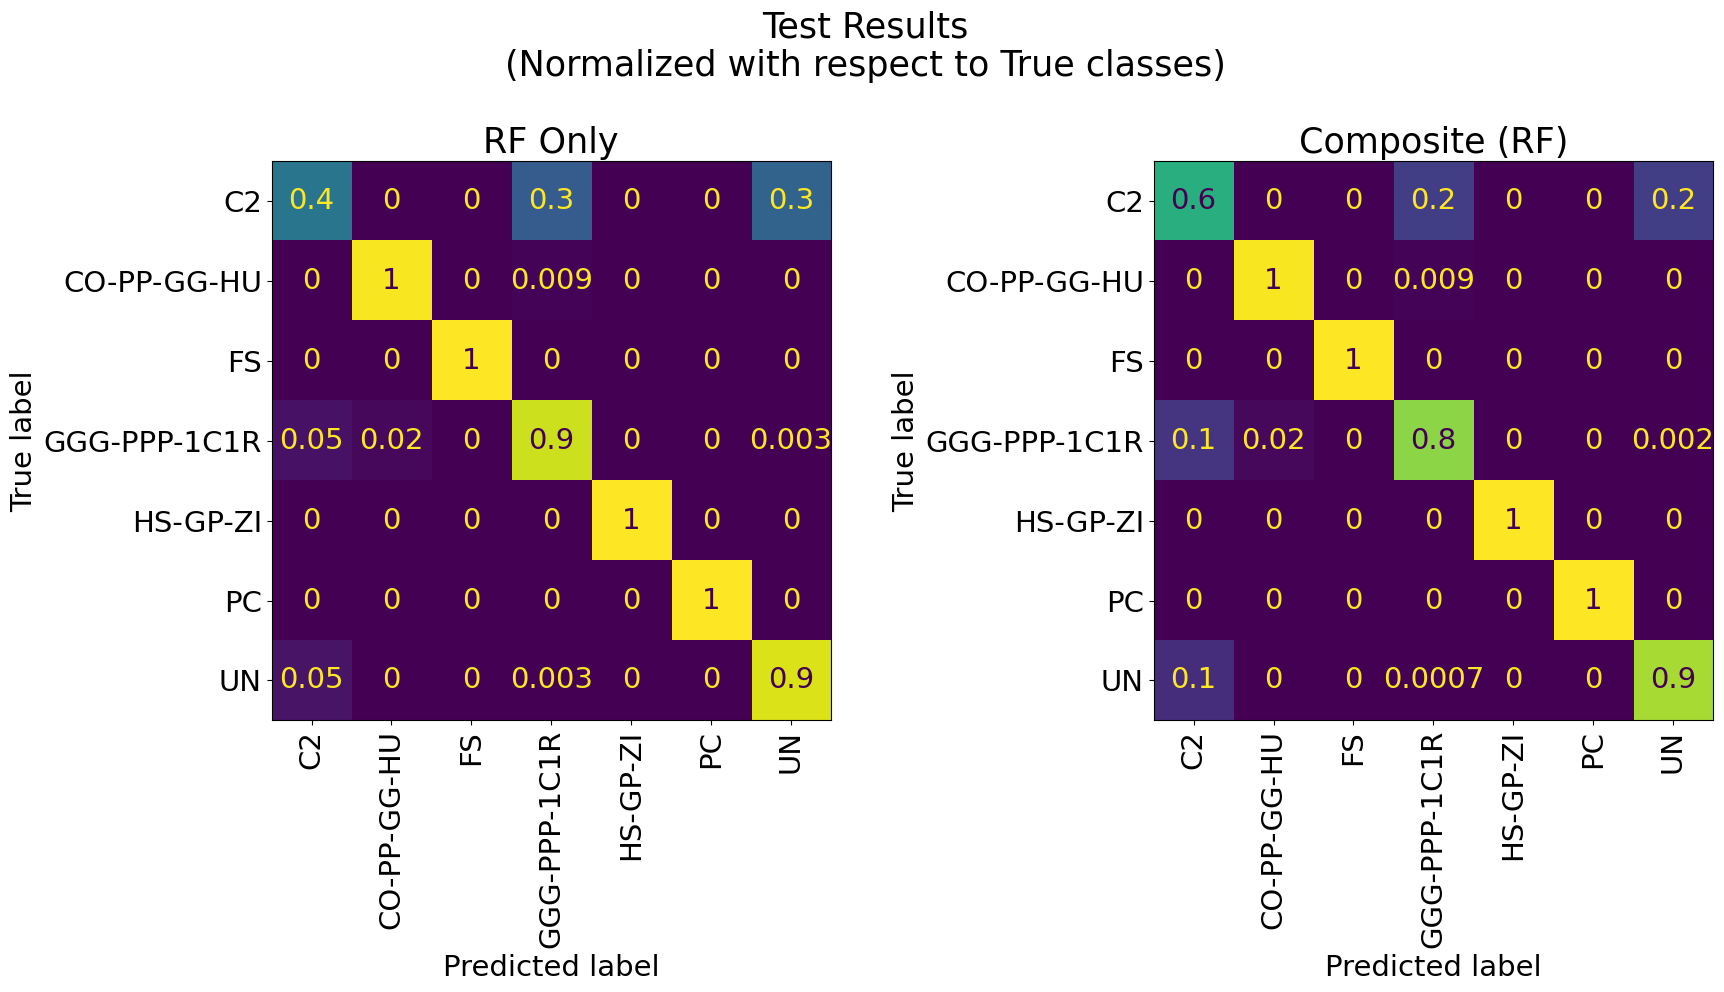

In [124]:
# final_clf_logit = CompositePredicter(
#     first_clf=hgs_rf_LR.best_estimator_, second_clf=hgs_logit_clf.best_estimator_
# )
final_clf_rf = CompositePredicter(
    first_clf=rf_model, second_clf=b_rf_clf
)
# final_clf_svc = CompositePredicter(
#     first_clf=hgs_rf_LR.best_estimator_, second_clf=hgs_svc_clf.best_estimator_
# )
# final_clf_svc_kernel = CompositePredicter(
#     first_clf=hgs_rf_pLR.best_estimator_, second_clf=hgs_svc_kernel_clf.best_estimator_
# )

fig = CM_report(
    y_true=y_test,
    y_pred=[
        y_pred_test,
        # final_clf_logit.predict(scaled_x_test_LR),
        final_clf_rf.predict(scaled_x_test_LR),
        # final_clf_svc.predict(scaled_x_test_LR),
        # final_clf_svc_kernel.predict(scaled_px_test_LR),
    ],
    title="Test Results\n(Normalized with respect to True classes)",
    experiment_names=[
        "RF Only",
        "Composite (RF)",
    ],
)
fig.savefig("confusion_matrix_composite.svg", format="svg", dpi=1200)



In [70]:
pd.DataFrame.from_dict(hgs_rf_LR.best_estimator_.get_params(), orient="index").T

,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
0,True,0.0,balanced,gini,3,sqrt,None,None,0.0,1,2,0.0,300,5,False,None,0,False


In [64]:
pd.DataFrame(
    classification_report(
        y_test,
        final_clf_rf.predict(scaled_x_test_LR),
        labels=hgs_rf_LR.best_estimator_.classes_,
        output_dict=True,
        digits=5,
    )
)


,C2,CO-PP-GG-HU,FS,GGG-PPP-1C1R,HS-GP-ZI,PC,UN,accuracy,macro avg,weighted avg
precision,0.045372,0.987549,1.0,0.945792,1.0,1.0,0.997536,0.909118,0.853750,0.988289
recall,0.625000,0.991429,1.0,0.828750,1.0,1.0,0.870538,0.909118,0.902245,0.909118
f1-score,0.084602,0.989485,1.0,0.883411,1.0,1.0,0.929720,0.909118,0.841031,0.944239
support,200.000000,2800.000000,400.0,1600.000000,3400.0,3600.0,18600.000000,0.909118,30600.000000,30600.000000
